# Camera sensor profiling with NN
### www.datosimagensonido.com
[Calibración de cámara digital con redes neuronales](https://www.datosimagensonido.com/)

## Libraries needed

In [1]:
import os
# from skimage import io  # read/write image formats (incl. 16-bit TIFF)
import imageio  # read/write image formats (incl. 16-bit TIFF)
import pickle  # to save/load model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor  # our MLP!

## Reading IT8 card white balanced RAW data

In [3]:
# RAW extraction with WB
# dcraw -v -r 2.299 1 1.805 1 -t 0 -o 0 -4 -T IT8.NEF

# Read image
# img = io.imread('IT8.tiff')
img = imageio.imread('IT8.tiff');

In [4]:
# Crop IT8 (6016 x 4016 pixels)
X1, X2 = 1201, 4810
Y1, Y2 = 832, 3240

img = img[Y1:Y2, X1:X2]

In [5]:
print(type(img))
print("RGB values range from", np.min(img), "to", np.max(img))
img.shape  # 24 x 16 squares -> 22 * 12 = 264 colour patches + 24 gray patches -> total: 288 examples

<class 'imageio.core.util.Array'>
RGB values range from 614 to 49076


(2408, 3609, 3)

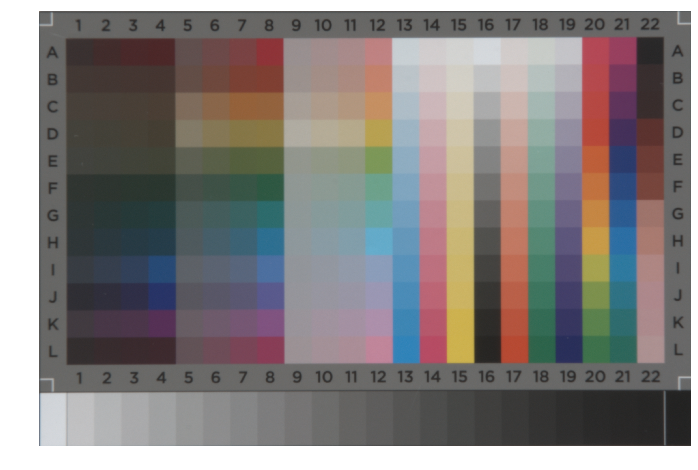

In [6]:
# Show IT8 chart
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2))
plt.axis('off');

In [23]:
# Calculate median RGB values over each patch
width = img.shape[1] / 24
height = img.shape[0] / 16
dX, dY = width / 7, height / 7  # safety margin

colours = np.zeros((22 * 12, 3))
grays = np.zeros((24, 3))

# Colour patches
k = 0
for j in range(12):
    Y1, Y2 = round((j + 1) * height + dY), round((j + 2) * height - dY)
    for i in range(22):
        X1, X2 = round((i + 1) * width + dX), round((i + 2) * width - dX)
        for c in range(3):
            colours[k, c] = np.median(img[Y1:Y2, X1:X2, c])        
            img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
            img[Y1:Y2, X1:X2, c] = colours[k, c]
        k = k + 1

# Gray patches
Y1, Y2 = round(14 * height + dY), round(16 * height - dY)
for i in range(24):
    X1, X2 = round((i + 0) * width + dX), round((i + 1) * width - dX)
    for c in range(3):
        grays[i, c] = np.median(img[Y1:Y2, X1:X2, c])
        img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
        img[Y1:Y2, X1:X2, c] = grays[i, c]

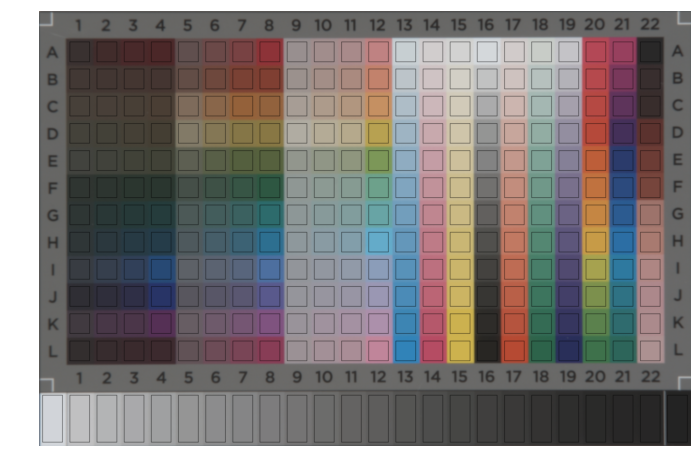

In [24]:
# Show used patches
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2), interpolation='bilinear')
plt.axis('off');

In [25]:
# Save image
# io.imsave('IT8_crop_median.tif', img)
imageio.imwrite('IT8_crop_median.tif', img)

## Reading IT8 card XYZ/Lab theoretical output values

In [ ]:
# 288 patches: 264 (0..263 = A1..L22) colour + 24 (264..287 = GS0..GS23) gray

In [26]:
# Features
R1 = colours[:, 0].flatten()
G1 = colours[:, 1].flatten()
B1 = colours[:, 2].flatten()

R2 = grays[:, 0].flatten()
G2 = grays[:, 1].flatten()
B2 = grays[:, 2].flatten()

X = np.concatenate((np.column_stack((R1, G1, B1)),
                    np.column_stack((R2, G2, B2)))) / 65535  # WB-RAW RGB in 0..1 range

In [34]:
# Target
IT8 = pd.read_csv('IT8.txt', sep='\t', decimal=',')
IT8.head()

,Patch,X,Y,Z,L,a,b
0,A1,3.273115,2.815129,1.956762,19.2878,9.7909,3.3837
1,A2,3.998580,2.721619,1.417480,18.8926,22.6662,8.5572
2,A3,4.991359,2.802497,1.360139,19.2349,34.4691,9.8527
3,A4,5.137458,2.693988,1.131962,18.7742,38.2558,12.0804
4,A5,12.086800,10.629437,7.330434,38.9492,13.3835,5.5036


In [35]:
Y = IT8[['X', 'Y', 'Z']].values / 100  # XYZ in 0..1 range

## Training the neural network

In [196]:
# Define and train MLP
for nn in [(), (200, 200)]:  # matrix and dense NN
    regr = MLPRegressor(solver='adam',  # solver algorithm ('sgd', lbfgs')
                        alpha=0,        # no L2 (ridge regression) regularization
                        hidden_layer_sizes=nn,  # tuple defining layers and nodes
                        activation='relu',      # hidden layers activation function (default 'relu') 
                                                # 'logistic' (sigmoid) works better than 'relu' and 'tanh'
                        max_iter=20800,         # max epochs
                        tol=0.000000000001,     # tolerance for early stopping
                        n_iter_no_change=1000,  # number of epochs to check tol
                        random_state=42,        # guarantee reproducible training
                        verbose=True)           # tell me a story
    regr.out_activation_ = 'identity'  # output layer activation function (default 'identity')
                                       # 'identity' is adequate for regression
    regr.fit(X, Y)
    
    # Save MLP
    with open('mlp_' + str(nn) + '_relu_identity.pkl', 'wb') as f:
        pickle.dump(regr, f)
    

Iteration 1, loss = 0.28753985
Iteration 2, loss = 0.28549286
Iteration 3, loss = 0.28349493
Iteration 4, loss = 0.28149400
Iteration 5, loss = 0.27947998
Iteration 6, loss = 0.27751551
Iteration 7, loss = 0.27554278
Iteration 8, loss = 0.27360466
Iteration 9, loss = 0.27165428
Iteration 10, loss = 0.26973792
Iteration 11, loss = 0.26781967
Iteration 12, loss = 0.26591856
Iteration 13, loss = 0.26404327
Iteration 14, loss = 0.26216056
Iteration 15, loss = 0.26031014
Iteration 16, loss = 0.25844394
Iteration 17, loss = 0.25660759
Iteration 18, loss = 0.25479091
Iteration 19, loss = 0.25298673
Iteration 20, loss = 0.25117131
Iteration 21, loss = 0.24941875
Iteration 22, loss = 0.24762620
Iteration 23, loss = 0.24585925
Iteration 24, loss = 0.24410673
Iteration 25, loss = 0.24238040
Iteration 26, loss = 0.24066375
Iteration 27, loss = 0.23893226
Iteration 28, loss = 0.23722722
Iteration 29, loss = 0.23554145
Iteration 30, loss = 0.23386300
Iteration 31, loss = 0.23218880
Iteration 32, los

Iteration 350, loss = 0.03357130
Iteration 351, loss = 0.03343682
Iteration 352, loss = 0.03330518
Iteration 353, loss = 0.03317669
Iteration 354, loss = 0.03304540
Iteration 355, loss = 0.03291555
Iteration 356, loss = 0.03278738
Iteration 357, loss = 0.03266031
Iteration 358, loss = 0.03253239
Iteration 359, loss = 0.03240680
Iteration 360, loss = 0.03228350
Iteration 361, loss = 0.03215785
Iteration 362, loss = 0.03203794
Iteration 363, loss = 0.03191507
Iteration 364, loss = 0.03179105
Iteration 365, loss = 0.03167095
Iteration 366, loss = 0.03155055
Iteration 367, loss = 0.03143409
Iteration 368, loss = 0.03131500
Iteration 369, loss = 0.03119938
Iteration 370, loss = 0.03108002
Iteration 371, loss = 0.03096554
Iteration 372, loss = 0.03085055
Iteration 373, loss = 0.03073638
Iteration 374, loss = 0.03062251
Iteration 375, loss = 0.03050969
Iteration 376, loss = 0.03039910
Iteration 377, loss = 0.03028716
Iteration 378, loss = 0.03017737
Iteration 379, loss = 0.03006597
Iteration 

Iteration 743, loss = 0.01018978
Iteration 744, loss = 0.01015961
Iteration 745, loss = 0.01012989
Iteration 746, loss = 0.01010020
Iteration 747, loss = 0.01007161
Iteration 748, loss = 0.01004215
Iteration 749, loss = 0.01001307
Iteration 750, loss = 0.00998402
Iteration 751, loss = 0.00995559
Iteration 752, loss = 0.00992575
Iteration 753, loss = 0.00989795
Iteration 754, loss = 0.00986918
Iteration 755, loss = 0.00984003
Iteration 756, loss = 0.00981126
Iteration 757, loss = 0.00978353
Iteration 758, loss = 0.00975479
Iteration 759, loss = 0.00972598
Iteration 760, loss = 0.00969838
Iteration 761, loss = 0.00966970
Iteration 762, loss = 0.00964083
Iteration 763, loss = 0.00961397
Iteration 764, loss = 0.00958560
Iteration 765, loss = 0.00955745
Iteration 766, loss = 0.00952972
Iteration 767, loss = 0.00950202
Iteration 768, loss = 0.00947429
Iteration 769, loss = 0.00944676
Iteration 770, loss = 0.00941967
Iteration 771, loss = 0.00939183
Iteration 772, loss = 0.00936418
Iteration 

Iteration 1147, loss = 0.00332552
Iteration 1148, loss = 0.00331755
Iteration 1149, loss = 0.00330984
Iteration 1150, loss = 0.00330203
Iteration 1151, loss = 0.00329433
Iteration 1152, loss = 0.00328647
Iteration 1153, loss = 0.00327897
Iteration 1154, loss = 0.00327130
Iteration 1155, loss = 0.00326364
Iteration 1156, loss = 0.00325617
Iteration 1157, loss = 0.00324857
Iteration 1158, loss = 0.00324110
Iteration 1159, loss = 0.00323361
Iteration 1160, loss = 0.00322624
Iteration 1161, loss = 0.00321854
Iteration 1162, loss = 0.00321132
Iteration 1163, loss = 0.00320392
Iteration 1164, loss = 0.00319650
Iteration 1165, loss = 0.00318927
Iteration 1166, loss = 0.00318182
Iteration 1167, loss = 0.00317456
Iteration 1168, loss = 0.00316734
Iteration 1169, loss = 0.00316014
Iteration 1170, loss = 0.00315300
Iteration 1171, loss = 0.00314561
Iteration 1172, loss = 0.00313859
Iteration 1173, loss = 0.00313144
Iteration 1174, loss = 0.00312444
Iteration 1175, loss = 0.00311729
Iteration 1176

Iteration 1538, loss = 0.00172689
Iteration 1539, loss = 0.00172505
Iteration 1540, loss = 0.00172319
Iteration 1541, loss = 0.00172147
Iteration 1542, loss = 0.00171947
Iteration 1543, loss = 0.00171779
Iteration 1544, loss = 0.00171588
Iteration 1545, loss = 0.00171408
Iteration 1546, loss = 0.00171228
Iteration 1547, loss = 0.00171048
Iteration 1548, loss = 0.00170871
Iteration 1549, loss = 0.00170685
Iteration 1550, loss = 0.00170505
Iteration 1551, loss = 0.00170329
Iteration 1552, loss = 0.00170153
Iteration 1553, loss = 0.00169970
Iteration 1554, loss = 0.00169798
Iteration 1555, loss = 0.00169615
Iteration 1556, loss = 0.00169431
Iteration 1557, loss = 0.00169267
Iteration 1558, loss = 0.00169083
Iteration 1559, loss = 0.00168904
Iteration 1560, loss = 0.00168728
Iteration 1561, loss = 0.00168560
Iteration 1562, loss = 0.00168376
Iteration 1563, loss = 0.00168209
Iteration 1564, loss = 0.00168034
Iteration 1565, loss = 0.00167870
Iteration 1566, loss = 0.00167699
Iteration 1567

Iteration 1949, loss = 0.00122629
Iteration 1950, loss = 0.00122537
Iteration 1951, loss = 0.00122441
Iteration 1952, loss = 0.00122346
Iteration 1953, loss = 0.00122251
Iteration 1954, loss = 0.00122158
Iteration 1955, loss = 0.00122071
Iteration 1956, loss = 0.00121979
Iteration 1957, loss = 0.00121890
Iteration 1958, loss = 0.00121809
Iteration 1959, loss = 0.00121711
Iteration 1960, loss = 0.00121624
Iteration 1961, loss = 0.00121528
Iteration 1962, loss = 0.00121434
Iteration 1963, loss = 0.00121343
Iteration 1964, loss = 0.00121253
Iteration 1965, loss = 0.00121162
Iteration 1966, loss = 0.00121075
Iteration 1967, loss = 0.00120984
Iteration 1968, loss = 0.00120884
Iteration 1969, loss = 0.00120801
Iteration 1970, loss = 0.00120708
Iteration 1971, loss = 0.00120623
Iteration 1972, loss = 0.00120529
Iteration 1973, loss = 0.00120438
Iteration 1974, loss = 0.00120344
Iteration 1975, loss = 0.00120252
Iteration 1976, loss = 0.00120165
Iteration 1977, loss = 0.00120078
Iteration 1978

Iteration 2354, loss = 0.00088099
Iteration 2355, loss = 0.00088019
Iteration 2356, loss = 0.00087941
Iteration 2357, loss = 0.00087865
Iteration 2358, loss = 0.00087780
Iteration 2359, loss = 0.00087695
Iteration 2360, loss = 0.00087619
Iteration 2361, loss = 0.00087534
Iteration 2362, loss = 0.00087457
Iteration 2363, loss = 0.00087372
Iteration 2364, loss = 0.00087292
Iteration 2365, loss = 0.00087209
Iteration 2366, loss = 0.00087133
Iteration 2367, loss = 0.00087051
Iteration 2368, loss = 0.00086969
Iteration 2369, loss = 0.00086885
Iteration 2370, loss = 0.00086803
Iteration 2371, loss = 0.00086723
Iteration 2372, loss = 0.00086645
Iteration 2373, loss = 0.00086562
Iteration 2374, loss = 0.00086488
Iteration 2375, loss = 0.00086401
Iteration 2376, loss = 0.00086319
Iteration 2377, loss = 0.00086237
Iteration 2378, loss = 0.00086161
Iteration 2379, loss = 0.00086082
Iteration 2380, loss = 0.00086000
Iteration 2381, loss = 0.00085919
Iteration 2382, loss = 0.00085836
Iteration 2383

Iteration 2753, loss = 0.00058058
Iteration 2754, loss = 0.00057985
Iteration 2755, loss = 0.00057922
Iteration 2756, loss = 0.00057855
Iteration 2757, loss = 0.00057789
Iteration 2758, loss = 0.00057723
Iteration 2759, loss = 0.00057654
Iteration 2760, loss = 0.00057588
Iteration 2761, loss = 0.00057518
Iteration 2762, loss = 0.00057447
Iteration 2763, loss = 0.00057389
Iteration 2764, loss = 0.00057311
Iteration 2765, loss = 0.00057242
Iteration 2766, loss = 0.00057173
Iteration 2767, loss = 0.00057106
Iteration 2768, loss = 0.00057036
Iteration 2769, loss = 0.00056976
Iteration 2770, loss = 0.00056905
Iteration 2771, loss = 0.00056839
Iteration 2772, loss = 0.00056774
Iteration 2773, loss = 0.00056710
Iteration 2774, loss = 0.00056636
Iteration 2775, loss = 0.00056576
Iteration 2776, loss = 0.00056500
Iteration 2777, loss = 0.00056443
Iteration 2778, loss = 0.00056371
Iteration 2779, loss = 0.00056310
Iteration 2780, loss = 0.00056237
Iteration 2781, loss = 0.00056174
Iteration 2782

Iteration 3146, loss = 0.00035047
Iteration 3147, loss = 0.00034994
Iteration 3148, loss = 0.00034947
Iteration 3149, loss = 0.00034893
Iteration 3150, loss = 0.00034849
Iteration 3151, loss = 0.00034800
Iteration 3152, loss = 0.00034751
Iteration 3153, loss = 0.00034706
Iteration 3154, loss = 0.00034658
Iteration 3155, loss = 0.00034611
Iteration 3156, loss = 0.00034561
Iteration 3157, loss = 0.00034515
Iteration 3158, loss = 0.00034468
Iteration 3159, loss = 0.00034423
Iteration 3160, loss = 0.00034378
Iteration 3161, loss = 0.00034326
Iteration 3162, loss = 0.00034277
Iteration 3163, loss = 0.00034230
Iteration 3164, loss = 0.00034192
Iteration 3165, loss = 0.00034150
Iteration 3166, loss = 0.00034100
Iteration 3167, loss = 0.00034048
Iteration 3168, loss = 0.00033999
Iteration 3169, loss = 0.00033949
Iteration 3170, loss = 0.00033899
Iteration 3171, loss = 0.00033856
Iteration 3172, loss = 0.00033808
Iteration 3173, loss = 0.00033769
Iteration 3174, loss = 0.00033722
Iteration 3175

Iteration 3575, loss = 0.00019730
Iteration 3576, loss = 0.00019707
Iteration 3577, loss = 0.00019684
Iteration 3578, loss = 0.00019661
Iteration 3579, loss = 0.00019638
Iteration 3580, loss = 0.00019610
Iteration 3581, loss = 0.00019588
Iteration 3582, loss = 0.00019567
Iteration 3583, loss = 0.00019546
Iteration 3584, loss = 0.00019538
Iteration 3585, loss = 0.00019505
Iteration 3586, loss = 0.00019469
Iteration 3587, loss = 0.00019453
Iteration 3588, loss = 0.00019427
Iteration 3589, loss = 0.00019404
Iteration 3590, loss = 0.00019379
Iteration 3591, loss = 0.00019356
Iteration 3592, loss = 0.00019329
Iteration 3593, loss = 0.00019306
Iteration 3594, loss = 0.00019287
Iteration 3595, loss = 0.00019261
Iteration 3596, loss = 0.00019244
Iteration 3597, loss = 0.00019217
Iteration 3598, loss = 0.00019194
Iteration 3599, loss = 0.00019175
Iteration 3600, loss = 0.00019151
Iteration 3601, loss = 0.00019128
Iteration 3602, loss = 0.00019104
Iteration 3603, loss = 0.00019079
Iteration 3604

Iteration 3987, loss = 0.00013656
Iteration 3988, loss = 0.00013658
Iteration 3989, loss = 0.00013641
Iteration 3990, loss = 0.00013635
Iteration 3991, loss = 0.00013634
Iteration 3992, loss = 0.00013634
Iteration 3993, loss = 0.00013618
Iteration 3994, loss = 0.00013612
Iteration 3995, loss = 0.00013613
Iteration 3996, loss = 0.00013599
Iteration 3997, loss = 0.00013586
Iteration 3998, loss = 0.00013584
Iteration 3999, loss = 0.00013573
Iteration 4000, loss = 0.00013562
Iteration 4001, loss = 0.00013557
Iteration 4002, loss = 0.00013572
Iteration 4003, loss = 0.00013550
Iteration 4004, loss = 0.00013533
Iteration 4005, loss = 0.00013526
Iteration 4006, loss = 0.00013524
Iteration 4007, loss = 0.00013531
Iteration 4008, loss = 0.00013525
Iteration 4009, loss = 0.00013520
Iteration 4010, loss = 0.00013499
Iteration 4011, loss = 0.00013490
Iteration 4012, loss = 0.00013485
Iteration 4013, loss = 0.00013489
Iteration 4014, loss = 0.00013474
Iteration 4015, loss = 0.00013468
Iteration 4016

Iteration 4376, loss = 0.00012225
Iteration 4377, loss = 0.00012220
Iteration 4378, loss = 0.00012225
Iteration 4379, loss = 0.00012218
Iteration 4380, loss = 0.00012215
Iteration 4381, loss = 0.00012215
Iteration 4382, loss = 0.00012212
Iteration 4383, loss = 0.00012213
Iteration 4384, loss = 0.00012212
Iteration 4385, loss = 0.00012218
Iteration 4386, loss = 0.00012213
Iteration 4387, loss = 0.00012215
Iteration 4388, loss = 0.00012207
Iteration 4389, loss = 0.00012205
Iteration 4390, loss = 0.00012204
Iteration 4391, loss = 0.00012208
Iteration 4392, loss = 0.00012200
Iteration 4393, loss = 0.00012197
Iteration 4394, loss = 0.00012199
Iteration 4395, loss = 0.00012209
Iteration 4396, loss = 0.00012208
Iteration 4397, loss = 0.00012201
Iteration 4398, loss = 0.00012198
Iteration 4399, loss = 0.00012203
Iteration 4400, loss = 0.00012194
Iteration 4401, loss = 0.00012193
Iteration 4402, loss = 0.00012193
Iteration 4403, loss = 0.00012194
Iteration 4404, loss = 0.00012207
Iteration 4405

Iteration 4799, loss = 0.00012041
Iteration 4800, loss = 0.00012051
Iteration 4801, loss = 0.00012037
Iteration 4802, loss = 0.00012038
Iteration 4803, loss = 0.00012038
Iteration 4804, loss = 0.00012041
Iteration 4805, loss = 0.00012038
Iteration 4806, loss = 0.00012036
Iteration 4807, loss = 0.00012037
Iteration 4808, loss = 0.00012036
Iteration 4809, loss = 0.00012039
Iteration 4810, loss = 0.00012037
Iteration 4811, loss = 0.00012037
Iteration 4812, loss = 0.00012037
Iteration 4813, loss = 0.00012058
Iteration 4814, loss = 0.00012039
Iteration 4815, loss = 0.00012045
Iteration 4816, loss = 0.00012046
Iteration 4817, loss = 0.00012050
Iteration 4818, loss = 0.00012056
Iteration 4819, loss = 0.00012042
Iteration 4820, loss = 0.00012038
Iteration 4821, loss = 0.00012037
Iteration 4822, loss = 0.00012042
Iteration 4823, loss = 0.00012040
Iteration 4824, loss = 0.00012037
Iteration 4825, loss = 0.00012059
Iteration 4826, loss = 0.00012040
Iteration 4827, loss = 0.00012038
Iteration 4828

Iteration 5205, loss = 0.00012035
Iteration 5206, loss = 0.00012028
Iteration 5207, loss = 0.00012035
Iteration 5208, loss = 0.00012055
Iteration 5209, loss = 0.00012066
Iteration 5210, loss = 0.00012049
Iteration 5211, loss = 0.00012040
Iteration 5212, loss = 0.00012050
Iteration 5213, loss = 0.00012047
Iteration 5214, loss = 0.00012045
Iteration 5215, loss = 0.00012047
Iteration 5216, loss = 0.00012036
Iteration 5217, loss = 0.00012040
Iteration 5218, loss = 0.00012044
Iteration 5219, loss = 0.00012038
Iteration 5220, loss = 0.00012039
Iteration 5221, loss = 0.00012045
Iteration 5222, loss = 0.00012037
Iteration 5223, loss = 0.00012037
Iteration 5224, loss = 0.00012031
Iteration 5225, loss = 0.00012043
Iteration 5226, loss = 0.00012039
Iteration 5227, loss = 0.00012040
Iteration 5228, loss = 0.00012038
Iteration 5229, loss = 0.00012037
Iteration 5230, loss = 0.00012035
Iteration 5231, loss = 0.00012042
Iteration 5232, loss = 0.00012039
Iteration 5233, loss = 0.00012035
Iteration 5234

Iteration 5576, loss = 0.00012056
Iteration 5577, loss = 0.00012033
Iteration 5578, loss = 0.00012028
Iteration 5579, loss = 0.00012071
Iteration 5580, loss = 0.00012066
Iteration 5581, loss = 0.00012048
Iteration 5582, loss = 0.00012035
Iteration 5583, loss = 0.00012047
Iteration 5584, loss = 0.00012055
Iteration 5585, loss = 0.00012054
Iteration 5586, loss = 0.00012049
Iteration 5587, loss = 0.00012035
Iteration 5588, loss = 0.00012033
Iteration 5589, loss = 0.00012050
Iteration 5590, loss = 0.00012050
Iteration 5591, loss = 0.00012041
Iteration 5592, loss = 0.00012043
Iteration 5593, loss = 0.00012034
Iteration 5594, loss = 0.00012032
Iteration 5595, loss = 0.00012112
Iteration 5596, loss = 0.00012024
Iteration 5597, loss = 0.00012072
Iteration 5598, loss = 0.00012066
Iteration 5599, loss = 0.00012058
Iteration 5600, loss = 0.00012054
Iteration 5601, loss = 0.00012045
Iteration 5602, loss = 0.00012037
Iteration 5603, loss = 0.00012035
Iteration 5604, loss = 0.00012044
Iteration 5605

Iteration 5980, loss = 0.00012061
Iteration 5981, loss = 0.00012049
Iteration 5982, loss = 0.00012039
Iteration 5983, loss = 0.00012038
Iteration 5984, loss = 0.00012034
Iteration 5985, loss = 0.00012039
Iteration 5986, loss = 0.00012038
Iteration 5987, loss = 0.00012030
Iteration 5988, loss = 0.00012037
Iteration 5989, loss = 0.00012058
Iteration 5990, loss = 0.00012067
Iteration 5991, loss = 0.00012052
Iteration 5992, loss = 0.00012045
Iteration 5993, loss = 0.00012037
Iteration 5994, loss = 0.00012049
Iteration 5995, loss = 0.00012035
Iteration 5996, loss = 0.00012079
Iteration 5997, loss = 0.00012075
Iteration 5998, loss = 0.00012047
Iteration 5999, loss = 0.00012037
Iteration 6000, loss = 0.00012042
Iteration 6001, loss = 0.00012061
Iteration 6002, loss = 0.00012070
Iteration 6003, loss = 0.00012052
Iteration 6004, loss = 0.00012028
Iteration 6005, loss = 0.00012056
Iteration 6006, loss = 0.00012070
Iteration 6007, loss = 0.00012060
Iteration 6008, loss = 0.00012047
Iteration 6009

Iteration 6385, loss = 0.00012038
Iteration 6386, loss = 0.00012009
Iteration 6387, loss = 0.00012066
Iteration 6388, loss = 0.00012142
Iteration 6389, loss = 0.00012154
Iteration 6390, loss = 0.00012130
Iteration 6391, loss = 0.00012043
Iteration 6392, loss = 0.00012058
Iteration 6393, loss = 0.00012077
Iteration 6394, loss = 0.00012118
Iteration 6395, loss = 0.00012102
Iteration 6396, loss = 0.00012062
Iteration 6397, loss = 0.00012051
Iteration 6398, loss = 0.00012041
Iteration 6399, loss = 0.00012059
Iteration 6400, loss = 0.00012034
Iteration 6401, loss = 0.00012050
Iteration 6402, loss = 0.00012071
Iteration 6403, loss = 0.00012053
Iteration 6404, loss = 0.00012036
Iteration 6405, loss = 0.00012041
Iteration 6406, loss = 0.00012054
Iteration 6407, loss = 0.00012049
Iteration 6408, loss = 0.00012031
Iteration 6409, loss = 0.00012044
Iteration 6410, loss = 0.00012049
Iteration 6411, loss = 0.00012061
Iteration 6412, loss = 0.00012069
Iteration 6413, loss = 0.00012039
Iteration 6414

Iteration 6770, loss = 0.00012070
Iteration 6771, loss = 0.00012053
Iteration 6772, loss = 0.00012041
Iteration 6773, loss = 0.00012049
Iteration 6774, loss = 0.00012053
Iteration 6775, loss = 0.00012037
Iteration 6776, loss = 0.00012030
Iteration 6777, loss = 0.00012089
Iteration 6778, loss = 0.00012068
Iteration 6779, loss = 0.00012040
Iteration 6780, loss = 0.00012027
Iteration 6781, loss = 0.00012033
Iteration 6782, loss = 0.00012057
Iteration 6783, loss = 0.00012085
Iteration 6784, loss = 0.00012089
Iteration 6785, loss = 0.00012058
Iteration 6786, loss = 0.00012026
Iteration 6787, loss = 0.00012041
Iteration 6788, loss = 0.00012075
Iteration 6789, loss = 0.00012112
Iteration 6790, loss = 0.00012078
Iteration 6791, loss = 0.00012024
Iteration 6792, loss = 0.00012064
Iteration 6793, loss = 0.00012077
Iteration 6794, loss = 0.00012060
Iteration 6795, loss = 0.00012042
Iteration 6796, loss = 0.00012033
Iteration 6797, loss = 0.00012028
Iteration 6798, loss = 0.00012042
Iteration 6799

Iteration 7156, loss = 0.00012078
Iteration 7157, loss = 0.00012043
Iteration 7158, loss = 0.00012038
Iteration 7159, loss = 0.00012032
Iteration 7160, loss = 0.00012041
Iteration 7161, loss = 0.00012043
Iteration 7162, loss = 0.00012063
Iteration 7163, loss = 0.00012047
Iteration 7164, loss = 0.00012047
Iteration 7165, loss = 0.00012039
Iteration 7166, loss = 0.00012073
Iteration 7167, loss = 0.00012029
Iteration 7168, loss = 0.00012025
Iteration 7169, loss = 0.00012065
Iteration 7170, loss = 0.00012117
Iteration 7171, loss = 0.00012121
Iteration 7172, loss = 0.00012083
Iteration 7173, loss = 0.00012048
Iteration 7174, loss = 0.00012042
Iteration 7175, loss = 0.00012050
Iteration 7176, loss = 0.00012062
Iteration 7177, loss = 0.00012059
Iteration 7178, loss = 0.00012041
Iteration 7179, loss = 0.00012043
Iteration 7180, loss = 0.00012059
Iteration 7181, loss = 0.00012056
Iteration 7182, loss = 0.00012038
Iteration 7183, loss = 0.00012036
Iteration 7184, loss = 0.00012036
Iteration 7185

Iteration 7543, loss = 0.00012041
Iteration 7544, loss = 0.00012035
Iteration 7545, loss = 0.00012034
Iteration 7546, loss = 0.00012037
Iteration 7547, loss = 0.00012036
Iteration 7548, loss = 0.00012038
Iteration 7549, loss = 0.00012040
Iteration 7550, loss = 0.00012034
Iteration 7551, loss = 0.00012053
Iteration 7552, loss = 0.00012041
Iteration 7553, loss = 0.00012061
Iteration 7554, loss = 0.00012105
Iteration 7555, loss = 0.00012068
Iteration 7556, loss = 0.00012025
Iteration 7557, loss = 0.00012044
Iteration 7558, loss = 0.00012078
Iteration 7559, loss = 0.00012080
Iteration 7560, loss = 0.00012054
Iteration 7561, loss = 0.00012046
Iteration 7562, loss = 0.00012064
Iteration 7563, loss = 0.00012036
Iteration 7564, loss = 0.00012046
Iteration 7565, loss = 0.00012045
Iteration 7566, loss = 0.00012089
Iteration 7567, loss = 0.00012042
Iteration 7568, loss = 0.00012033
Iteration 7569, loss = 0.00012065
Iteration 7570, loss = 0.00012089
Iteration 7571, loss = 0.00012097
Iteration 7572

Iteration 7946, loss = 0.00012049
Iteration 7947, loss = 0.00012036
Iteration 7948, loss = 0.00012027
Iteration 7949, loss = 0.00012088
Iteration 7950, loss = 0.00012103
Iteration 7951, loss = 0.00012072
Iteration 7952, loss = 0.00012045
Iteration 7953, loss = 0.00012033
Iteration 7954, loss = 0.00012066
Iteration 7955, loss = 0.00012073
Iteration 7956, loss = 0.00012036
Iteration 7957, loss = 0.00012048
Iteration 7958, loss = 0.00012097
Iteration 7959, loss = 0.00012119
Iteration 7960, loss = 0.00012037
Iteration 7961, loss = 0.00012032
Iteration 7962, loss = 0.00012034
Iteration 7963, loss = 0.00012051
Iteration 7964, loss = 0.00012054
Iteration 7965, loss = 0.00012050
Iteration 7966, loss = 0.00012048
Iteration 7967, loss = 0.00012060
Iteration 7968, loss = 0.00012032
Iteration 7969, loss = 0.00012040
Iteration 7970, loss = 0.00012047
Iteration 7971, loss = 0.00012053
Iteration 7972, loss = 0.00012039
Iteration 7973, loss = 0.00012038
Iteration 7974, loss = 0.00012040
Iteration 7975

Iteration 8355, loss = 0.00012039
Iteration 8356, loss = 0.00012057
Iteration 8357, loss = 0.00012065
Iteration 8358, loss = 0.00012077
Iteration 8359, loss = 0.00012056
Iteration 8360, loss = 0.00012042
Iteration 8361, loss = 0.00012018
Iteration 8362, loss = 0.00012060
Iteration 8363, loss = 0.00012112
Iteration 8364, loss = 0.00012105
Iteration 8365, loss = 0.00012057
Iteration 8366, loss = 0.00012041
Iteration 8367, loss = 0.00012052
Iteration 8368, loss = 0.00012069
Iteration 8369, loss = 0.00012061
Iteration 8370, loss = 0.00012037
Iteration 8371, loss = 0.00012035
Iteration 8372, loss = 0.00012042
Iteration 8373, loss = 0.00012051
Iteration 8374, loss = 0.00012039
Iteration 8375, loss = 0.00012088
Iteration 8376, loss = 0.00012046
Iteration 8377, loss = 0.00012036
Iteration 8378, loss = 0.00012035
Iteration 8379, loss = 0.00012035
Iteration 8380, loss = 0.00012045
Iteration 8381, loss = 0.00012071
Iteration 8382, loss = 0.00012033
Iteration 8383, loss = 0.00012034
Iteration 8384

Iteration 125, loss = 0.00009069
Iteration 126, loss = 0.00008971
Iteration 127, loss = 0.00009011
Iteration 128, loss = 0.00008954
Iteration 129, loss = 0.00008939
Iteration 130, loss = 0.00008917
Iteration 131, loss = 0.00008892
Iteration 132, loss = 0.00008872
Iteration 133, loss = 0.00008887
Iteration 134, loss = 0.00008844
Iteration 135, loss = 0.00008845
Iteration 136, loss = 0.00008892
Iteration 137, loss = 0.00008828
Iteration 138, loss = 0.00008923
Iteration 139, loss = 0.00008819
Iteration 140, loss = 0.00008944
Iteration 141, loss = 0.00008753
Iteration 142, loss = 0.00009023
Iteration 143, loss = 0.00008870
Iteration 144, loss = 0.00008907
Iteration 145, loss = 0.00008758
Iteration 146, loss = 0.00008770
Iteration 147, loss = 0.00008753
Iteration 148, loss = 0.00008870
Iteration 149, loss = 0.00008645
Iteration 150, loss = 0.00009119
Iteration 151, loss = 0.00008723
Iteration 152, loss = 0.00009140
Iteration 153, loss = 0.00008778
Iteration 154, loss = 0.00009026
Iteration 

Iteration 414, loss = 0.00007635
Iteration 415, loss = 0.00007528
Iteration 416, loss = 0.00007490
Iteration 417, loss = 0.00007432
Iteration 418, loss = 0.00007461
Iteration 419, loss = 0.00007521
Iteration 420, loss = 0.00007548
Iteration 421, loss = 0.00007664
Iteration 422, loss = 0.00007517
Iteration 423, loss = 0.00007505
Iteration 424, loss = 0.00007673
Iteration 425, loss = 0.00007623
Iteration 426, loss = 0.00007739
Iteration 427, loss = 0.00007443
Iteration 428, loss = 0.00007900
Iteration 429, loss = 0.00007427
Iteration 430, loss = 0.00007806
Iteration 431, loss = 0.00008091
Iteration 432, loss = 0.00007545
Iteration 433, loss = 0.00007889
Iteration 434, loss = 0.00007977
Iteration 435, loss = 0.00007518
Iteration 436, loss = 0.00007840
Iteration 437, loss = 0.00007619
Iteration 438, loss = 0.00007604
Iteration 439, loss = 0.00007410
Iteration 440, loss = 0.00007633
Iteration 441, loss = 0.00007503
Iteration 442, loss = 0.00007412
Iteration 443, loss = 0.00007367
Iteration 

Iteration 666, loss = 0.00007219
Iteration 667, loss = 0.00007092
Iteration 668, loss = 0.00007098
Iteration 669, loss = 0.00007038
Iteration 670, loss = 0.00007123
Iteration 671, loss = 0.00007058
Iteration 672, loss = 0.00007067
Iteration 673, loss = 0.00007071
Iteration 674, loss = 0.00007282
Iteration 675, loss = 0.00007055
Iteration 676, loss = 0.00007165
Iteration 677, loss = 0.00007027
Iteration 678, loss = 0.00007125
Iteration 679, loss = 0.00006963
Iteration 680, loss = 0.00006976
Iteration 681, loss = 0.00006942
Iteration 682, loss = 0.00007028
Iteration 683, loss = 0.00006927
Iteration 684, loss = 0.00006965
Iteration 685, loss = 0.00007175
Iteration 686, loss = 0.00006981
Iteration 687, loss = 0.00007101
Iteration 688, loss = 0.00007077
Iteration 689, loss = 0.00007259
Iteration 690, loss = 0.00007437
Iteration 691, loss = 0.00007239
Iteration 692, loss = 0.00006927
Iteration 693, loss = 0.00007824
Iteration 694, loss = 0.00007454
Iteration 695, loss = 0.00007337
Iteration 

Iteration 918, loss = 0.00006620
Iteration 919, loss = 0.00006868
Iteration 920, loss = 0.00006793
Iteration 921, loss = 0.00006678
Iteration 922, loss = 0.00006614
Iteration 923, loss = 0.00007053
Iteration 924, loss = 0.00006816
Iteration 925, loss = 0.00006878
Iteration 926, loss = 0.00006688
Iteration 927, loss = 0.00007015
Iteration 928, loss = 0.00007079
Iteration 929, loss = 0.00007127
Iteration 930, loss = 0.00007104
Iteration 931, loss = 0.00006926
Iteration 932, loss = 0.00006611
Iteration 933, loss = 0.00007319
Iteration 934, loss = 0.00007190
Iteration 935, loss = 0.00006748
Iteration 936, loss = 0.00006730
Iteration 937, loss = 0.00006748
Iteration 938, loss = 0.00006997
Iteration 939, loss = 0.00006600
Iteration 940, loss = 0.00006704
Iteration 941, loss = 0.00006891
Iteration 942, loss = 0.00006758
Iteration 943, loss = 0.00006852
Iteration 944, loss = 0.00007175
Iteration 945, loss = 0.00007145
Iteration 946, loss = 0.00006874
Iteration 947, loss = 0.00007245
Iteration 

Iteration 1164, loss = 0.00006979
Iteration 1165, loss = 0.00006737
Iteration 1166, loss = 0.00006481
Iteration 1167, loss = 0.00006799
Iteration 1168, loss = 0.00006318
Iteration 1169, loss = 0.00006515
Iteration 1170, loss = 0.00006432
Iteration 1171, loss = 0.00006552
Iteration 1172, loss = 0.00006875
Iteration 1173, loss = 0.00007275
Iteration 1174, loss = 0.00006794
Iteration 1175, loss = 0.00006552
Iteration 1176, loss = 0.00006759
Iteration 1177, loss = 0.00006638
Iteration 1178, loss = 0.00006863
Iteration 1179, loss = 0.00006629
Iteration 1180, loss = 0.00006512
Iteration 1181, loss = 0.00006639
Iteration 1182, loss = 0.00006644
Iteration 1183, loss = 0.00006906
Iteration 1184, loss = 0.00006585
Iteration 1185, loss = 0.00006755
Iteration 1186, loss = 0.00006747
Iteration 1187, loss = 0.00006871
Iteration 1188, loss = 0.00006633
Iteration 1189, loss = 0.00006633
Iteration 1190, loss = 0.00006737
Iteration 1191, loss = 0.00006647
Iteration 1192, loss = 0.00006695
Iteration 1193

Iteration 1418, loss = 0.00006183
Iteration 1419, loss = 0.00006167
Iteration 1420, loss = 0.00006172
Iteration 1421, loss = 0.00006067
Iteration 1422, loss = 0.00006264
Iteration 1423, loss = 0.00006151
Iteration 1424, loss = 0.00006083
Iteration 1425, loss = 0.00006262
Iteration 1426, loss = 0.00006462
Iteration 1427, loss = 0.00006139
Iteration 1428, loss = 0.00006276
Iteration 1429, loss = 0.00006520
Iteration 1430, loss = 0.00006788
Iteration 1431, loss = 0.00006391
Iteration 1432, loss = 0.00006261
Iteration 1433, loss = 0.00006218
Iteration 1434, loss = 0.00006194
Iteration 1435, loss = 0.00006447
Iteration 1436, loss = 0.00006138
Iteration 1437, loss = 0.00006144
Iteration 1438, loss = 0.00006457
Iteration 1439, loss = 0.00006525
Iteration 1440, loss = 0.00006951
Iteration 1441, loss = 0.00007189
Iteration 1442, loss = 0.00007225
Iteration 1443, loss = 0.00007463
Iteration 1444, loss = 0.00006969
Iteration 1445, loss = 0.00007230
Iteration 1446, loss = 0.00007555
Iteration 1447

Iteration 1672, loss = 0.00005827
Iteration 1673, loss = 0.00005899
Iteration 1674, loss = 0.00005779
Iteration 1675, loss = 0.00006029
Iteration 1676, loss = 0.00005984
Iteration 1677, loss = 0.00006112
Iteration 1678, loss = 0.00006374
Iteration 1679, loss = 0.00006537
Iteration 1680, loss = 0.00006275
Iteration 1681, loss = 0.00006066
Iteration 1682, loss = 0.00006112
Iteration 1683, loss = 0.00006119
Iteration 1684, loss = 0.00005847
Iteration 1685, loss = 0.00006371
Iteration 1686, loss = 0.00006631
Iteration 1687, loss = 0.00006205
Iteration 1688, loss = 0.00006118
Iteration 1689, loss = 0.00006545
Iteration 1690, loss = 0.00006485
Iteration 1691, loss = 0.00006921
Iteration 1692, loss = 0.00007401
Iteration 1693, loss = 0.00006915
Iteration 1694, loss = 0.00006588
Iteration 1695, loss = 0.00006176
Iteration 1696, loss = 0.00006551
Iteration 1697, loss = 0.00007062
Iteration 1698, loss = 0.00007651
Iteration 1699, loss = 0.00008977
Iteration 1700, loss = 0.00008797
Iteration 1701

Iteration 1927, loss = 0.00005695
Iteration 1928, loss = 0.00005708
Iteration 1929, loss = 0.00005769
Iteration 1930, loss = 0.00005756
Iteration 1931, loss = 0.00005730
Iteration 1932, loss = 0.00005827
Iteration 1933, loss = 0.00006070
Iteration 1934, loss = 0.00005723
Iteration 1935, loss = 0.00005739
Iteration 1936, loss = 0.00005649
Iteration 1937, loss = 0.00005876
Iteration 1938, loss = 0.00006446
Iteration 1939, loss = 0.00006243
Iteration 1940, loss = 0.00005585
Iteration 1941, loss = 0.00005706
Iteration 1942, loss = 0.00005614
Iteration 1943, loss = 0.00005817
Iteration 1944, loss = 0.00006701
Iteration 1945, loss = 0.00006582
Iteration 1946, loss = 0.00005796
Iteration 1947, loss = 0.00005884
Iteration 1948, loss = 0.00006027
Iteration 1949, loss = 0.00005716
Iteration 1950, loss = 0.00005752
Iteration 1951, loss = 0.00005937
Iteration 1952, loss = 0.00005705
Iteration 1953, loss = 0.00005616
Iteration 1954, loss = 0.00005636
Iteration 1955, loss = 0.00005724
Iteration 1956

Iteration 2182, loss = 0.00005660
Iteration 2183, loss = 0.00005352
Iteration 2184, loss = 0.00006280
Iteration 2185, loss = 0.00005402
Iteration 2186, loss = 0.00005352
Iteration 2187, loss = 0.00005270
Iteration 2188, loss = 0.00005697
Iteration 2189, loss = 0.00005487
Iteration 2190, loss = 0.00005914
Iteration 2191, loss = 0.00005450
Iteration 2192, loss = 0.00005405
Iteration 2193, loss = 0.00005516
Iteration 2194, loss = 0.00005561
Iteration 2195, loss = 0.00005444
Iteration 2196, loss = 0.00005363
Iteration 2197, loss = 0.00005331
Iteration 2198, loss = 0.00005278
Iteration 2199, loss = 0.00005520
Iteration 2200, loss = 0.00005359
Iteration 2201, loss = 0.00005379
Iteration 2202, loss = 0.00005752
Iteration 2203, loss = 0.00006660
Iteration 2204, loss = 0.00005617
Iteration 2205, loss = 0.00005511
Iteration 2206, loss = 0.00005409
Iteration 2207, loss = 0.00005253
Iteration 2208, loss = 0.00005566
Iteration 2209, loss = 0.00005473
Iteration 2210, loss = 0.00005729
Iteration 2211

Iteration 2426, loss = 0.00005111
Iteration 2427, loss = 0.00005461
Iteration 2428, loss = 0.00005118
Iteration 2429, loss = 0.00005475
Iteration 2430, loss = 0.00005591
Iteration 2431, loss = 0.00005434
Iteration 2432, loss = 0.00006060
Iteration 2433, loss = 0.00005256
Iteration 2434, loss = 0.00005243
Iteration 2435, loss = 0.00005386
Iteration 2436, loss = 0.00005408
Iteration 2437, loss = 0.00005609
Iteration 2438, loss = 0.00005961
Iteration 2439, loss = 0.00005817
Iteration 2440, loss = 0.00005601
Iteration 2441, loss = 0.00005722
Iteration 2442, loss = 0.00005635
Iteration 2443, loss = 0.00005331
Iteration 2444, loss = 0.00005161
Iteration 2445, loss = 0.00005391
Iteration 2446, loss = 0.00005421
Iteration 2447, loss = 0.00005383
Iteration 2448, loss = 0.00005330
Iteration 2449, loss = 0.00005097
Iteration 2450, loss = 0.00005274
Iteration 2451, loss = 0.00005222
Iteration 2452, loss = 0.00005808
Iteration 2453, loss = 0.00006661
Iteration 2454, loss = 0.00005622
Iteration 2455

Iteration 2673, loss = 0.00007246
Iteration 2674, loss = 0.00007640
Iteration 2675, loss = 0.00006123
Iteration 2676, loss = 0.00006336
Iteration 2677, loss = 0.00005840
Iteration 2678, loss = 0.00005919
Iteration 2679, loss = 0.00005443
Iteration 2680, loss = 0.00005450
Iteration 2681, loss = 0.00005422
Iteration 2682, loss = 0.00005712
Iteration 2683, loss = 0.00006179
Iteration 2684, loss = 0.00005439
Iteration 2685, loss = 0.00005179
Iteration 2686, loss = 0.00005394
Iteration 2687, loss = 0.00005063
Iteration 2688, loss = 0.00005064
Iteration 2689, loss = 0.00004966
Iteration 2690, loss = 0.00004916
Iteration 2691, loss = 0.00005271
Iteration 2692, loss = 0.00005019
Iteration 2693, loss = 0.00004936
Iteration 2694, loss = 0.00004863
Iteration 2695, loss = 0.00004901
Iteration 2696, loss = 0.00004931
Iteration 2697, loss = 0.00004861
Iteration 2698, loss = 0.00004865
Iteration 2699, loss = 0.00004865
Iteration 2700, loss = 0.00004785
Iteration 2701, loss = 0.00005185
Iteration 2702

Iteration 2925, loss = 0.00005883
Iteration 2926, loss = 0.00005113
Iteration 2927, loss = 0.00004810
Iteration 2928, loss = 0.00004745
Iteration 2929, loss = 0.00004992
Iteration 2930, loss = 0.00004756
Iteration 2931, loss = 0.00004836
Iteration 2932, loss = 0.00004705
Iteration 2933, loss = 0.00004758
Iteration 2934, loss = 0.00004902
Iteration 2935, loss = 0.00004754
Iteration 2936, loss = 0.00004694
Iteration 2937, loss = 0.00004664
Iteration 2938, loss = 0.00004885
Iteration 2939, loss = 0.00005441
Iteration 2940, loss = 0.00005160
Iteration 2941, loss = 0.00005452
Iteration 2942, loss = 0.00005115
Iteration 2943, loss = 0.00005020
Iteration 2944, loss = 0.00005025
Iteration 2945, loss = 0.00004713
Iteration 2946, loss = 0.00004747
Iteration 2947, loss = 0.00005538
Iteration 2948, loss = 0.00004939
Iteration 2949, loss = 0.00004839
Iteration 2950, loss = 0.00004821
Iteration 2951, loss = 0.00005051
Iteration 2952, loss = 0.00004815
Iteration 2953, loss = 0.00004812
Iteration 2954

Iteration 3167, loss = 0.00005091
Iteration 3168, loss = 0.00004903
Iteration 3169, loss = 0.00004937
Iteration 3170, loss = 0.00004759
Iteration 3171, loss = 0.00004600
Iteration 3172, loss = 0.00004703
Iteration 3173, loss = 0.00005058
Iteration 3174, loss = 0.00005384
Iteration 3175, loss = 0.00006063
Iteration 3176, loss = 0.00004888
Iteration 3177, loss = 0.00004794
Iteration 3178, loss = 0.00004877
Iteration 3179, loss = 0.00004729
Iteration 3180, loss = 0.00004792
Iteration 3181, loss = 0.00004851
Iteration 3182, loss = 0.00004924
Iteration 3183, loss = 0.00004833
Iteration 3184, loss = 0.00004674
Iteration 3185, loss = 0.00004804
Iteration 3186, loss = 0.00004781
Iteration 3187, loss = 0.00004735
Iteration 3188, loss = 0.00004693
Iteration 3189, loss = 0.00004625
Iteration 3190, loss = 0.00004611
Iteration 3191, loss = 0.00004868
Iteration 3192, loss = 0.00004558
Iteration 3193, loss = 0.00004694
Iteration 3194, loss = 0.00005003
Iteration 3195, loss = 0.00004689
Iteration 3196

Iteration 3438, loss = 0.00004506
Iteration 3439, loss = 0.00004658
Iteration 3440, loss = 0.00005723
Iteration 3441, loss = 0.00004678
Iteration 3442, loss = 0.00004472
Iteration 3443, loss = 0.00004648
Iteration 3444, loss = 0.00004562
Iteration 3445, loss = 0.00004871
Iteration 3446, loss = 0.00004644
Iteration 3447, loss = 0.00004722
Iteration 3448, loss = 0.00004691
Iteration 3449, loss = 0.00005045
Iteration 3450, loss = 0.00005041
Iteration 3451, loss = 0.00004728
Iteration 3452, loss = 0.00005107
Iteration 3453, loss = 0.00004727
Iteration 3454, loss = 0.00004875
Iteration 3455, loss = 0.00004535
Iteration 3456, loss = 0.00005094
Iteration 3457, loss = 0.00004663
Iteration 3458, loss = 0.00004859
Iteration 3459, loss = 0.00004809
Iteration 3460, loss = 0.00004730
Iteration 3461, loss = 0.00004601
Iteration 3462, loss = 0.00004509
Iteration 3463, loss = 0.00004886
Iteration 3464, loss = 0.00005657
Iteration 3465, loss = 0.00005342
Iteration 3466, loss = 0.00005059
Iteration 3467

Iteration 3697, loss = 0.00004854
Iteration 3698, loss = 0.00005422
Iteration 3699, loss = 0.00006050
Iteration 3700, loss = 0.00005512
Iteration 3701, loss = 0.00005071
Iteration 3702, loss = 0.00005066
Iteration 3703, loss = 0.00004694
Iteration 3704, loss = 0.00004853
Iteration 3705, loss = 0.00005686
Iteration 3706, loss = 0.00006188
Iteration 3707, loss = 0.00006200
Iteration 3708, loss = 0.00004821
Iteration 3709, loss = 0.00004596
Iteration 3710, loss = 0.00004681
Iteration 3711, loss = 0.00005062
Iteration 3712, loss = 0.00004638
Iteration 3713, loss = 0.00004904
Iteration 3714, loss = 0.00005049
Iteration 3715, loss = 0.00004968
Iteration 3716, loss = 0.00004551
Iteration 3717, loss = 0.00004599
Iteration 3718, loss = 0.00004803
Iteration 3719, loss = 0.00005586
Iteration 3720, loss = 0.00004466
Iteration 3721, loss = 0.00004383
Iteration 3722, loss = 0.00004696
Iteration 3723, loss = 0.00004497
Iteration 3724, loss = 0.00004686
Iteration 3725, loss = 0.00004774
Iteration 3726

Iteration 3951, loss = 0.00004343
Iteration 3952, loss = 0.00004410
Iteration 3953, loss = 0.00004515
Iteration 3954, loss = 0.00004559
Iteration 3955, loss = 0.00004347
Iteration 3956, loss = 0.00004444
Iteration 3957, loss = 0.00004577
Iteration 3958, loss = 0.00004740
Iteration 3959, loss = 0.00004648
Iteration 3960, loss = 0.00005130
Iteration 3961, loss = 0.00005160
Iteration 3962, loss = 0.00004737
Iteration 3963, loss = 0.00004497
Iteration 3964, loss = 0.00004675
Iteration 3965, loss = 0.00005406
Iteration 3966, loss = 0.00004694
Iteration 3967, loss = 0.00005098
Iteration 3968, loss = 0.00004959
Iteration 3969, loss = 0.00004730
Iteration 3970, loss = 0.00004977
Iteration 3971, loss = 0.00004500
Iteration 3972, loss = 0.00004869
Iteration 3973, loss = 0.00004357
Iteration 3974, loss = 0.00004886
Iteration 3975, loss = 0.00004409
Iteration 3976, loss = 0.00004222
Iteration 3977, loss = 0.00004643
Iteration 3978, loss = 0.00004436
Iteration 3979, loss = 0.00004265
Iteration 3980

Iteration 4201, loss = 0.00004753
Iteration 4202, loss = 0.00004707
Iteration 4203, loss = 0.00004793
Iteration 4204, loss = 0.00004792
Iteration 4205, loss = 0.00004341
Iteration 4206, loss = 0.00004294
Iteration 4207, loss = 0.00004252
Iteration 4208, loss = 0.00004171
Iteration 4209, loss = 0.00004140
Iteration 4210, loss = 0.00004124
Iteration 4211, loss = 0.00004405
Iteration 4212, loss = 0.00004505
Iteration 4213, loss = 0.00004475
Iteration 4214, loss = 0.00004276
Iteration 4215, loss = 0.00004338
Iteration 4216, loss = 0.00004328
Iteration 4217, loss = 0.00004789
Iteration 4218, loss = 0.00004281
Iteration 4219, loss = 0.00004153
Iteration 4220, loss = 0.00004226
Iteration 4221, loss = 0.00004757
Iteration 4222, loss = 0.00005058
Iteration 4223, loss = 0.00004531
Iteration 4224, loss = 0.00004197
Iteration 4225, loss = 0.00004551
Iteration 4226, loss = 0.00005499
Iteration 4227, loss = 0.00005319
Iteration 4228, loss = 0.00004355
Iteration 4229, loss = 0.00004671
Iteration 4230

Iteration 4458, loss = 0.00004437
Iteration 4459, loss = 0.00004514
Iteration 4460, loss = 0.00004352
Iteration 4461, loss = 0.00004355
Iteration 4462, loss = 0.00004298
Iteration 4463, loss = 0.00004998
Iteration 4464, loss = 0.00004237
Iteration 4465, loss = 0.00004414
Iteration 4466, loss = 0.00004555
Iteration 4467, loss = 0.00004848
Iteration 4468, loss = 0.00004245
Iteration 4469, loss = 0.00004111
Iteration 4470, loss = 0.00004516
Iteration 4471, loss = 0.00004092
Iteration 4472, loss = 0.00004192
Iteration 4473, loss = 0.00004125
Iteration 4474, loss = 0.00004138
Iteration 4475, loss = 0.00004122
Iteration 4476, loss = 0.00004208
Iteration 4477, loss = 0.00004119
Iteration 4478, loss = 0.00004113
Iteration 4479, loss = 0.00004031
Iteration 4480, loss = 0.00004045
Iteration 4481, loss = 0.00004079
Iteration 4482, loss = 0.00004152
Iteration 4483, loss = 0.00004123
Iteration 4484, loss = 0.00004287
Iteration 4485, loss = 0.00004124
Iteration 4486, loss = 0.00004059
Iteration 4487

Iteration 4707, loss = 0.00004391
Iteration 4708, loss = 0.00004068
Iteration 4709, loss = 0.00004696
Iteration 4710, loss = 0.00004947
Iteration 4711, loss = 0.00004478
Iteration 4712, loss = 0.00004387
Iteration 4713, loss = 0.00004255
Iteration 4714, loss = 0.00004061
Iteration 4715, loss = 0.00004171
Iteration 4716, loss = 0.00003913
Iteration 4717, loss = 0.00004235
Iteration 4718, loss = 0.00004086
Iteration 4719, loss = 0.00004148
Iteration 4720, loss = 0.00004350
Iteration 4721, loss = 0.00004225
Iteration 4722, loss = 0.00004309
Iteration 4723, loss = 0.00004202
Iteration 4724, loss = 0.00004330
Iteration 4725, loss = 0.00004209
Iteration 4726, loss = 0.00004358
Iteration 4727, loss = 0.00004093
Iteration 4728, loss = 0.00003930
Iteration 4729, loss = 0.00004381
Iteration 4730, loss = 0.00004138
Iteration 4731, loss = 0.00004415
Iteration 4732, loss = 0.00004183
Iteration 4733, loss = 0.00004060
Iteration 4734, loss = 0.00004207
Iteration 4735, loss = 0.00004500
Iteration 4736

Iteration 4951, loss = 0.00004583
Iteration 4952, loss = 0.00004570
Iteration 4953, loss = 0.00004075
Iteration 4954, loss = 0.00004322
Iteration 4955, loss = 0.00004626
Iteration 4956, loss = 0.00004738
Iteration 4957, loss = 0.00004068
Iteration 4958, loss = 0.00004037
Iteration 4959, loss = 0.00004086
Iteration 4960, loss = 0.00004777
Iteration 4961, loss = 0.00005007
Iteration 4962, loss = 0.00005086
Iteration 4963, loss = 0.00004300
Iteration 4964, loss = 0.00005258
Iteration 4965, loss = 0.00003865
Iteration 4966, loss = 0.00004625
Iteration 4967, loss = 0.00005689
Iteration 4968, loss = 0.00005779
Iteration 4969, loss = 0.00005121
Iteration 4970, loss = 0.00004900
Iteration 4971, loss = 0.00005043
Iteration 4972, loss = 0.00005072
Iteration 4973, loss = 0.00004981
Iteration 4974, loss = 0.00004208
Iteration 4975, loss = 0.00004909
Iteration 4976, loss = 0.00004787
Iteration 4977, loss = 0.00003960
Iteration 4978, loss = 0.00005115
Iteration 4979, loss = 0.00005550
Iteration 4980

Iteration 5198, loss = 0.00003971
Iteration 5199, loss = 0.00003779
Iteration 5200, loss = 0.00003794
Iteration 5201, loss = 0.00003918
Iteration 5202, loss = 0.00003817
Iteration 5203, loss = 0.00004041
Iteration 5204, loss = 0.00003866
Iteration 5205, loss = 0.00003929
Iteration 5206, loss = 0.00003934
Iteration 5207, loss = 0.00003981
Iteration 5208, loss = 0.00003857
Iteration 5209, loss = 0.00003928
Iteration 5210, loss = 0.00003984
Iteration 5211, loss = 0.00004203
Iteration 5212, loss = 0.00004388
Iteration 5213, loss = 0.00003819
Iteration 5214, loss = 0.00003833
Iteration 5215, loss = 0.00004079
Iteration 5216, loss = 0.00003994
Iteration 5217, loss = 0.00003962
Iteration 5218, loss = 0.00003748
Iteration 5219, loss = 0.00003794
Iteration 5220, loss = 0.00003826
Iteration 5221, loss = 0.00003831
Iteration 5222, loss = 0.00003821
Iteration 5223, loss = 0.00003746
Iteration 5224, loss = 0.00003978
Iteration 5225, loss = 0.00003927
Iteration 5226, loss = 0.00003979
Iteration 5227

Iteration 5452, loss = 0.00004015
Iteration 5453, loss = 0.00003905
Iteration 5454, loss = 0.00004448
Iteration 5455, loss = 0.00004181
Iteration 5456, loss = 0.00003818
Iteration 5457, loss = 0.00003868
Iteration 5458, loss = 0.00003892
Iteration 5459, loss = 0.00004069
Iteration 5460, loss = 0.00004000
Iteration 5461, loss = 0.00003946
Iteration 5462, loss = 0.00004658
Iteration 5463, loss = 0.00005307
Iteration 5464, loss = 0.00004880
Iteration 5465, loss = 0.00005356
Iteration 5466, loss = 0.00005193
Iteration 5467, loss = 0.00004709
Iteration 5468, loss = 0.00004927
Iteration 5469, loss = 0.00005995
Iteration 5470, loss = 0.00005420
Iteration 5471, loss = 0.00004675
Iteration 5472, loss = 0.00004556
Iteration 5473, loss = 0.00004618
Iteration 5474, loss = 0.00004355
Iteration 5475, loss = 0.00004315
Iteration 5476, loss = 0.00005022
Iteration 5477, loss = 0.00005169
Iteration 5478, loss = 0.00005598
Iteration 5479, loss = 0.00005805
Iteration 5480, loss = 0.00005169
Iteration 5481

Iteration 5704, loss = 0.00004114
Iteration 5705, loss = 0.00003694
Iteration 5706, loss = 0.00004719
Iteration 5707, loss = 0.00003731
Iteration 5708, loss = 0.00003846
Iteration 5709, loss = 0.00003944
Iteration 5710, loss = 0.00003835
Iteration 5711, loss = 0.00003694
Iteration 5712, loss = 0.00003752
Iteration 5713, loss = 0.00003669
Iteration 5714, loss = 0.00003764
Iteration 5715, loss = 0.00003590
Iteration 5716, loss = 0.00004006
Iteration 5717, loss = 0.00003980
Iteration 5718, loss = 0.00004217
Iteration 5719, loss = 0.00004335
Iteration 5720, loss = 0.00004918
Iteration 5721, loss = 0.00005083
Iteration 5722, loss = 0.00004546
Iteration 5723, loss = 0.00004128
Iteration 5724, loss = 0.00004436
Iteration 5725, loss = 0.00003987
Iteration 5726, loss = 0.00004158
Iteration 5727, loss = 0.00004708
Iteration 5728, loss = 0.00004517
Iteration 5729, loss = 0.00005404
Iteration 5730, loss = 0.00004708
Iteration 5731, loss = 0.00004762
Iteration 5732, loss = 0.00004889
Iteration 5733

Iteration 5957, loss = 0.00003843
Iteration 5958, loss = 0.00003851
Iteration 5959, loss = 0.00003799
Iteration 5960, loss = 0.00003656
Iteration 5961, loss = 0.00003680
Iteration 5962, loss = 0.00004082
Iteration 5963, loss = 0.00004202
Iteration 5964, loss = 0.00003855
Iteration 5965, loss = 0.00003935
Iteration 5966, loss = 0.00004255
Iteration 5967, loss = 0.00004153
Iteration 5968, loss = 0.00004005
Iteration 5969, loss = 0.00004341
Iteration 5970, loss = 0.00004380
Iteration 5971, loss = 0.00004307
Iteration 5972, loss = 0.00003830
Iteration 5973, loss = 0.00004141
Iteration 5974, loss = 0.00004412
Iteration 5975, loss = 0.00004501
Iteration 5976, loss = 0.00005428
Iteration 5977, loss = 0.00004610
Iteration 5978, loss = 0.00004077
Iteration 5979, loss = 0.00004440
Iteration 5980, loss = 0.00003810
Iteration 5981, loss = 0.00004094
Iteration 5982, loss = 0.00003900
Iteration 5983, loss = 0.00003741
Iteration 5984, loss = 0.00003942
Iteration 5985, loss = 0.00003938
Iteration 5986

Iteration 6208, loss = 0.00003595
Iteration 6209, loss = 0.00003606
Iteration 6210, loss = 0.00003501
Iteration 6211, loss = 0.00003625
Iteration 6212, loss = 0.00003735
Iteration 6213, loss = 0.00004032
Iteration 6214, loss = 0.00003982
Iteration 6215, loss = 0.00003601
Iteration 6216, loss = 0.00003732
Iteration 6217, loss = 0.00003677
Iteration 6218, loss = 0.00003736
Iteration 6219, loss = 0.00004054
Iteration 6220, loss = 0.00004272
Iteration 6221, loss = 0.00003525
Iteration 6222, loss = 0.00003919
Iteration 6223, loss = 0.00003629
Iteration 6224, loss = 0.00003837
Iteration 6225, loss = 0.00003664
Iteration 6226, loss = 0.00003781
Iteration 6227, loss = 0.00003602
Iteration 6228, loss = 0.00003591
Iteration 6229, loss = 0.00003602
Iteration 6230, loss = 0.00003653
Iteration 6231, loss = 0.00003624
Iteration 6232, loss = 0.00003703
Iteration 6233, loss = 0.00003753
Iteration 6234, loss = 0.00003528
Iteration 6235, loss = 0.00003862
Iteration 6236, loss = 0.00003792
Iteration 6237

Iteration 6460, loss = 0.00003677
Iteration 6461, loss = 0.00004176
Iteration 6462, loss = 0.00003965
Iteration 6463, loss = 0.00003726
Iteration 6464, loss = 0.00003646
Iteration 6465, loss = 0.00003723
Iteration 6466, loss = 0.00003854
Iteration 6467, loss = 0.00003928
Iteration 6468, loss = 0.00003780
Iteration 6469, loss = 0.00003628
Iteration 6470, loss = 0.00004082
Iteration 6471, loss = 0.00003885
Iteration 6472, loss = 0.00004018
Iteration 6473, loss = 0.00003851
Iteration 6474, loss = 0.00003783
Iteration 6475, loss = 0.00003973
Iteration 6476, loss = 0.00003467
Iteration 6477, loss = 0.00003973
Iteration 6478, loss = 0.00004285
Iteration 6479, loss = 0.00003804
Iteration 6480, loss = 0.00003933
Iteration 6481, loss = 0.00003934
Iteration 6482, loss = 0.00004353
Iteration 6483, loss = 0.00003978
Iteration 6484, loss = 0.00004062
Iteration 6485, loss = 0.00003930
Iteration 6486, loss = 0.00003735
Iteration 6487, loss = 0.00003748
Iteration 6488, loss = 0.00003814
Iteration 6489

Iteration 6710, loss = 0.00003504
Iteration 6711, loss = 0.00003606
Iteration 6712, loss = 0.00003737
Iteration 6713, loss = 0.00003762
Iteration 6714, loss = 0.00004180
Iteration 6715, loss = 0.00003542
Iteration 6716, loss = 0.00003666
Iteration 6717, loss = 0.00003628
Iteration 6718, loss = 0.00003526
Iteration 6719, loss = 0.00003507
Iteration 6720, loss = 0.00003534
Iteration 6721, loss = 0.00003537
Iteration 6722, loss = 0.00003476
Iteration 6723, loss = 0.00003389
Iteration 6724, loss = 0.00003475
Iteration 6725, loss = 0.00003683
Iteration 6726, loss = 0.00003528
Iteration 6727, loss = 0.00003527
Iteration 6728, loss = 0.00003558
Iteration 6729, loss = 0.00003674
Iteration 6730, loss = 0.00003578
Iteration 6731, loss = 0.00003471
Iteration 6732, loss = 0.00003499
Iteration 6733, loss = 0.00003543
Iteration 6734, loss = 0.00003695
Iteration 6735, loss = 0.00003413
Iteration 6736, loss = 0.00003941
Iteration 6737, loss = 0.00004859
Iteration 6738, loss = 0.00004374
Iteration 6739

Iteration 6970, loss = 0.00004061
Iteration 6971, loss = 0.00004047
Iteration 6972, loss = 0.00003795
Iteration 6973, loss = 0.00003855
Iteration 6974, loss = 0.00003769
Iteration 6975, loss = 0.00003711
Iteration 6976, loss = 0.00003484
Iteration 6977, loss = 0.00003852
Iteration 6978, loss = 0.00004313
Iteration 6979, loss = 0.00003625
Iteration 6980, loss = 0.00003526
Iteration 6981, loss = 0.00003452
Iteration 6982, loss = 0.00003443
Iteration 6983, loss = 0.00003481
Iteration 6984, loss = 0.00003592
Iteration 6985, loss = 0.00003781
Iteration 6986, loss = 0.00004017
Iteration 6987, loss = 0.00003614
Iteration 6988, loss = 0.00003489
Iteration 6989, loss = 0.00003534
Iteration 6990, loss = 0.00003512
Iteration 6991, loss = 0.00003400
Iteration 6992, loss = 0.00003649
Iteration 6993, loss = 0.00003753
Iteration 6994, loss = 0.00003770
Iteration 6995, loss = 0.00003834
Iteration 6996, loss = 0.00003934
Iteration 6997, loss = 0.00003821
Iteration 6998, loss = 0.00003689
Iteration 6999

Iteration 7237, loss = 0.00003915
Iteration 7238, loss = 0.00003986
Iteration 7239, loss = 0.00003953
Iteration 7240, loss = 0.00004462
Iteration 7241, loss = 0.00004839
Iteration 7242, loss = 0.00004306
Iteration 7243, loss = 0.00004359
Iteration 7244, loss = 0.00003772
Iteration 7245, loss = 0.00003551
Iteration 7246, loss = 0.00005487
Iteration 7247, loss = 0.00005953
Iteration 7248, loss = 0.00004920
Iteration 7249, loss = 0.00004622
Iteration 7250, loss = 0.00004335
Iteration 7251, loss = 0.00004221
Iteration 7252, loss = 0.00004072
Iteration 7253, loss = 0.00003808
Iteration 7254, loss = 0.00003505
Iteration 7255, loss = 0.00005150
Iteration 7256, loss = 0.00004235
Iteration 7257, loss = 0.00004248
Iteration 7258, loss = 0.00004220
Iteration 7259, loss = 0.00003787
Iteration 7260, loss = 0.00003891
Iteration 7261, loss = 0.00004136
Iteration 7262, loss = 0.00003780
Iteration 7263, loss = 0.00003908
Iteration 7264, loss = 0.00003560
Iteration 7265, loss = 0.00003518
Iteration 7266

Iteration 7497, loss = 0.00003810
Iteration 7498, loss = 0.00003804
Iteration 7499, loss = 0.00003589
Iteration 7500, loss = 0.00003959
Iteration 7501, loss = 0.00004345
Iteration 7502, loss = 0.00004036
Iteration 7503, loss = 0.00003549
Iteration 7504, loss = 0.00003935
Iteration 7505, loss = 0.00003990
Iteration 7506, loss = 0.00003503
Iteration 7507, loss = 0.00003500
Iteration 7508, loss = 0.00003328
Iteration 7509, loss = 0.00003335
Iteration 7510, loss = 0.00003502
Iteration 7511, loss = 0.00003469
Iteration 7512, loss = 0.00003361
Iteration 7513, loss = 0.00003556
Iteration 7514, loss = 0.00003821
Iteration 7515, loss = 0.00003736
Iteration 7516, loss = 0.00003351
Iteration 7517, loss = 0.00003275
Iteration 7518, loss = 0.00004070
Iteration 7519, loss = 0.00004547
Iteration 7520, loss = 0.00003843
Iteration 7521, loss = 0.00003333
Iteration 7522, loss = 0.00003457
Iteration 7523, loss = 0.00003603
Iteration 7524, loss = 0.00003268
Iteration 7525, loss = 0.00003282
Iteration 7526

Iteration 7763, loss = 0.00003182
Iteration 7764, loss = 0.00003142
Iteration 7765, loss = 0.00003150
Iteration 7766, loss = 0.00003125
Iteration 7767, loss = 0.00003178
Iteration 7768, loss = 0.00003252
Iteration 7769, loss = 0.00003350
Iteration 7770, loss = 0.00003269
Iteration 7771, loss = 0.00003205
Iteration 7772, loss = 0.00003350
Iteration 7773, loss = 0.00003381
Iteration 7774, loss = 0.00003322
Iteration 7775, loss = 0.00003240
Iteration 7776, loss = 0.00003290
Iteration 7777, loss = 0.00003497
Iteration 7778, loss = 0.00003678
Iteration 7779, loss = 0.00003226
Iteration 7780, loss = 0.00003373
Iteration 7781, loss = 0.00003343
Iteration 7782, loss = 0.00003375
Iteration 7783, loss = 0.00003196
Iteration 7784, loss = 0.00003432
Iteration 7785, loss = 0.00003622
Iteration 7786, loss = 0.00003947
Iteration 7787, loss = 0.00003435
Iteration 7788, loss = 0.00003473
Iteration 7789, loss = 0.00003363
Iteration 7790, loss = 0.00003385
Iteration 7791, loss = 0.00003217
Iteration 7792

Iteration 8027, loss = 0.00003476
Iteration 8028, loss = 0.00003603
Iteration 8029, loss = 0.00004141
Iteration 8030, loss = 0.00004361
Iteration 8031, loss = 0.00004775
Iteration 8032, loss = 0.00003942
Iteration 8033, loss = 0.00003997
Iteration 8034, loss = 0.00004123
Iteration 8035, loss = 0.00004099
Iteration 8036, loss = 0.00003932
Iteration 8037, loss = 0.00003472
Iteration 8038, loss = 0.00003504
Iteration 8039, loss = 0.00003671
Iteration 8040, loss = 0.00003834
Iteration 8041, loss = 0.00005357
Iteration 8042, loss = 0.00005446
Iteration 8043, loss = 0.00004421
Iteration 8044, loss = 0.00003646
Iteration 8045, loss = 0.00004265
Iteration 8046, loss = 0.00003741
Iteration 8047, loss = 0.00003633
Iteration 8048, loss = 0.00003797
Iteration 8049, loss = 0.00003219
Iteration 8050, loss = 0.00003452
Iteration 8051, loss = 0.00003625
Iteration 8052, loss = 0.00003255
Iteration 8053, loss = 0.00003168
Iteration 8054, loss = 0.00003386
Iteration 8055, loss = 0.00003270
Iteration 8056

Iteration 8293, loss = 0.00003159
Iteration 8294, loss = 0.00003237
Iteration 8295, loss = 0.00003468
Iteration 8296, loss = 0.00003253
Iteration 8297, loss = 0.00003189
Iteration 8298, loss = 0.00003258
Iteration 8299, loss = 0.00003316
Iteration 8300, loss = 0.00003132
Iteration 8301, loss = 0.00003087
Iteration 8302, loss = 0.00003414
Iteration 8303, loss = 0.00004196
Iteration 8304, loss = 0.00005052
Iteration 8305, loss = 0.00004470
Iteration 8306, loss = 0.00003843
Iteration 8307, loss = 0.00003984
Iteration 8308, loss = 0.00003619
Iteration 8309, loss = 0.00004645
Iteration 8310, loss = 0.00003866
Iteration 8311, loss = 0.00003993
Iteration 8312, loss = 0.00004005
Iteration 8313, loss = 0.00003859
Iteration 8314, loss = 0.00003787
Iteration 8315, loss = 0.00003839
Iteration 8316, loss = 0.00003643
Iteration 8317, loss = 0.00003668
Iteration 8318, loss = 0.00003543
Iteration 8319, loss = 0.00003649
Iteration 8320, loss = 0.00003711
Iteration 8321, loss = 0.00003505
Iteration 8322

Iteration 8556, loss = 0.00003344
Iteration 8557, loss = 0.00003128
Iteration 8558, loss = 0.00003601
Iteration 8559, loss = 0.00003098
Iteration 8560, loss = 0.00003335
Iteration 8561, loss = 0.00003077
Iteration 8562, loss = 0.00003088
Iteration 8563, loss = 0.00003126
Iteration 8564, loss = 0.00003203
Iteration 8565, loss = 0.00003101
Iteration 8566, loss = 0.00003112
Iteration 8567, loss = 0.00003182
Iteration 8568, loss = 0.00003269
Iteration 8569, loss = 0.00003308
Iteration 8570, loss = 0.00003640
Iteration 8571, loss = 0.00003632
Iteration 8572, loss = 0.00003477
Iteration 8573, loss = 0.00003386
Iteration 8574, loss = 0.00003516
Iteration 8575, loss = 0.00003447
Iteration 8576, loss = 0.00003283
Iteration 8577, loss = 0.00003296
Iteration 8578, loss = 0.00003121
Iteration 8579, loss = 0.00003365
Iteration 8580, loss = 0.00003423
Iteration 8581, loss = 0.00003315
Iteration 8582, loss = 0.00003044
Iteration 8583, loss = 0.00003287
Iteration 8584, loss = 0.00003063
Iteration 8585

Iteration 8816, loss = 0.00003075
Iteration 8817, loss = 0.00003170
Iteration 8818, loss = 0.00003257
Iteration 8819, loss = 0.00003709
Iteration 8820, loss = 0.00004002
Iteration 8821, loss = 0.00003651
Iteration 8822, loss = 0.00003715
Iteration 8823, loss = 0.00003527
Iteration 8824, loss = 0.00003228
Iteration 8825, loss = 0.00003190
Iteration 8826, loss = 0.00003392
Iteration 8827, loss = 0.00003417
Iteration 8828, loss = 0.00003242
Iteration 8829, loss = 0.00003136
Iteration 8830, loss = 0.00003084
Iteration 8831, loss = 0.00002979
Iteration 8832, loss = 0.00003021
Iteration 8833, loss = 0.00003076
Iteration 8834, loss = 0.00003191
Iteration 8835, loss = 0.00003350
Iteration 8836, loss = 0.00003574
Iteration 8837, loss = 0.00003071
Iteration 8838, loss = 0.00003013
Iteration 8839, loss = 0.00003010
Iteration 8840, loss = 0.00002884
Iteration 8841, loss = 0.00002999
Iteration 8842, loss = 0.00003030
Iteration 8843, loss = 0.00002942
Iteration 8844, loss = 0.00003106
Iteration 8845

Iteration 9071, loss = 0.00003105
Iteration 9072, loss = 0.00003303
Iteration 9073, loss = 0.00003490
Iteration 9074, loss = 0.00003347
Iteration 9075, loss = 0.00003237
Iteration 9076, loss = 0.00003335
Iteration 9077, loss = 0.00003265
Iteration 9078, loss = 0.00003005
Iteration 9079, loss = 0.00003098
Iteration 9080, loss = 0.00003118
Iteration 9081, loss = 0.00003345
Iteration 9082, loss = 0.00002991
Iteration 9083, loss = 0.00003105
Iteration 9084, loss = 0.00003056
Iteration 9085, loss = 0.00003205
Iteration 9086, loss = 0.00003207
Iteration 9087, loss = 0.00003100
Iteration 9088, loss = 0.00002941
Iteration 9089, loss = 0.00003065
Iteration 9090, loss = 0.00003416
Iteration 9091, loss = 0.00003280
Iteration 9092, loss = 0.00003337
Iteration 9093, loss = 0.00003196
Iteration 9094, loss = 0.00003487
Iteration 9095, loss = 0.00003747
Iteration 9096, loss = 0.00003450
Iteration 9097, loss = 0.00003153
Iteration 9098, loss = 0.00003339
Iteration 9099, loss = 0.00003226
Iteration 9100

Iteration 9326, loss = 0.00004230
Iteration 9327, loss = 0.00004124
Iteration 9328, loss = 0.00004335
Iteration 9329, loss = 0.00003480
Iteration 9330, loss = 0.00003309
Iteration 9331, loss = 0.00003042
Iteration 9332, loss = 0.00003292
Iteration 9333, loss = 0.00003014
Iteration 9334, loss = 0.00003135
Iteration 9335, loss = 0.00003026
Iteration 9336, loss = 0.00003228
Iteration 9337, loss = 0.00003587
Iteration 9338, loss = 0.00003570
Iteration 9339, loss = 0.00003574
Iteration 9340, loss = 0.00004039
Iteration 9341, loss = 0.00003277
Iteration 9342, loss = 0.00003859
Iteration 9343, loss = 0.00003516
Iteration 9344, loss = 0.00003940
Iteration 9345, loss = 0.00003996
Iteration 9346, loss = 0.00002947
Iteration 9347, loss = 0.00003222
Iteration 9348, loss = 0.00003879
Iteration 9349, loss = 0.00003449
Iteration 9350, loss = 0.00003276
Iteration 9351, loss = 0.00002957
Iteration 9352, loss = 0.00003390
Iteration 9353, loss = 0.00003179
Iteration 9354, loss = 0.00003334
Iteration 9355

Iteration 9582, loss = 0.00003784
Iteration 9583, loss = 0.00003194
Iteration 9584, loss = 0.00003495
Iteration 9585, loss = 0.00003289
Iteration 9586, loss = 0.00003402
Iteration 9587, loss = 0.00002939
Iteration 9588, loss = 0.00002987
Iteration 9589, loss = 0.00003062
Iteration 9590, loss = 0.00003393
Iteration 9591, loss = 0.00003448
Iteration 9592, loss = 0.00003268
Iteration 9593, loss = 0.00003068
Iteration 9594, loss = 0.00003036
Iteration 9595, loss = 0.00003267
Iteration 9596, loss = 0.00003074
Iteration 9597, loss = 0.00002792
Iteration 9598, loss = 0.00002956
Iteration 9599, loss = 0.00002832
Iteration 9600, loss = 0.00002899
Iteration 9601, loss = 0.00003018
Iteration 9602, loss = 0.00003145
Iteration 9603, loss = 0.00002891
Iteration 9604, loss = 0.00003022
Iteration 9605, loss = 0.00002943
Iteration 9606, loss = 0.00002948
Iteration 9607, loss = 0.00002838
Iteration 9608, loss = 0.00002958
Iteration 9609, loss = 0.00002843
Iteration 9610, loss = 0.00003041
Iteration 9611

Iteration 9839, loss = 0.00002948
Iteration 9840, loss = 0.00003431
Iteration 9841, loss = 0.00003316
Iteration 9842, loss = 0.00002748
Iteration 9843, loss = 0.00003023
Iteration 9844, loss = 0.00002769
Iteration 9845, loss = 0.00002914
Iteration 9846, loss = 0.00002893
Iteration 9847, loss = 0.00002962
Iteration 9848, loss = 0.00003000
Iteration 9849, loss = 0.00002814
Iteration 9850, loss = 0.00002770
Iteration 9851, loss = 0.00003150
Iteration 9852, loss = 0.00003119
Iteration 9853, loss = 0.00002811
Iteration 9854, loss = 0.00002993
Iteration 9855, loss = 0.00002880
Iteration 9856, loss = 0.00002935
Iteration 9857, loss = 0.00003000
Iteration 9858, loss = 0.00003087
Iteration 9859, loss = 0.00002883
Iteration 9860, loss = 0.00002767
Iteration 9861, loss = 0.00002970
Iteration 9862, loss = 0.00002973
Iteration 9863, loss = 0.00003000
Iteration 9864, loss = 0.00002923
Iteration 9865, loss = 0.00002808
Iteration 9866, loss = 0.00003205
Iteration 9867, loss = 0.00003590
Iteration 9868

Iteration 10091, loss = 0.00002992
Iteration 10092, loss = 0.00002844
Iteration 10093, loss = 0.00002829
Iteration 10094, loss = 0.00002995
Iteration 10095, loss = 0.00002843
Iteration 10096, loss = 0.00002881
Iteration 10097, loss = 0.00002963
Iteration 10098, loss = 0.00002864
Iteration 10099, loss = 0.00003014
Iteration 10100, loss = 0.00003150
Iteration 10101, loss = 0.00002837
Iteration 10102, loss = 0.00002817
Iteration 10103, loss = 0.00003056
Iteration 10104, loss = 0.00003798
Iteration 10105, loss = 0.00004733
Iteration 10106, loss = 0.00004688
Iteration 10107, loss = 0.00004085
Iteration 10108, loss = 0.00004054
Iteration 10109, loss = 0.00003383
Iteration 10110, loss = 0.00003926
Iteration 10111, loss = 0.00002952
Iteration 10112, loss = 0.00004712
Iteration 10113, loss = 0.00003597
Iteration 10114, loss = 0.00003200
Iteration 10115, loss = 0.00002896
Iteration 10116, loss = 0.00003207
Iteration 10117, loss = 0.00003179
Iteration 10118, loss = 0.00003376
Iteration 10119, los

Iteration 10340, loss = 0.00002851
Iteration 10341, loss = 0.00003012
Iteration 10342, loss = 0.00002762
Iteration 10343, loss = 0.00003923
Iteration 10344, loss = 0.00003972
Iteration 10345, loss = 0.00003205
Iteration 10346, loss = 0.00002894
Iteration 10347, loss = 0.00003103
Iteration 10348, loss = 0.00002700
Iteration 10349, loss = 0.00003339
Iteration 10350, loss = 0.00003243
Iteration 10351, loss = 0.00003099
Iteration 10352, loss = 0.00002998
Iteration 10353, loss = 0.00003093
Iteration 10354, loss = 0.00002860
Iteration 10355, loss = 0.00002782
Iteration 10356, loss = 0.00003033
Iteration 10357, loss = 0.00003510
Iteration 10358, loss = 0.00003267
Iteration 10359, loss = 0.00002814
Iteration 10360, loss = 0.00002919
Iteration 10361, loss = 0.00002702
Iteration 10362, loss = 0.00003015
Iteration 10363, loss = 0.00002744
Iteration 10364, loss = 0.00003061
Iteration 10365, loss = 0.00003008
Iteration 10366, loss = 0.00002713
Iteration 10367, loss = 0.00002884
Iteration 10368, los

Iteration 10591, loss = 0.00003069
Iteration 10592, loss = 0.00002790
Iteration 10593, loss = 0.00002730
Iteration 10594, loss = 0.00002814
Iteration 10595, loss = 0.00002742
Iteration 10596, loss = 0.00002707
Iteration 10597, loss = 0.00002728
Iteration 10598, loss = 0.00002551
Iteration 10599, loss = 0.00002575
Iteration 10600, loss = 0.00002645
Iteration 10601, loss = 0.00002631
Iteration 10602, loss = 0.00002721
Iteration 10603, loss = 0.00002983
Iteration 10604, loss = 0.00002937
Iteration 10605, loss = 0.00002715
Iteration 10606, loss = 0.00002869
Iteration 10607, loss = 0.00002947
Iteration 10608, loss = 0.00002808
Iteration 10609, loss = 0.00002768
Iteration 10610, loss = 0.00002795
Iteration 10611, loss = 0.00003176
Iteration 10612, loss = 0.00003245
Iteration 10613, loss = 0.00003169
Iteration 10614, loss = 0.00003393
Iteration 10615, loss = 0.00003131
Iteration 10616, loss = 0.00002899
Iteration 10617, loss = 0.00002926
Iteration 10618, loss = 0.00003016
Iteration 10619, los

Iteration 10835, loss = 0.00003963
Iteration 10836, loss = 0.00003751
Iteration 10837, loss = 0.00003558
Iteration 10838, loss = 0.00003434
Iteration 10839, loss = 0.00003237
Iteration 10840, loss = 0.00002974
Iteration 10841, loss = 0.00003562
Iteration 10842, loss = 0.00002882
Iteration 10843, loss = 0.00003200
Iteration 10844, loss = 0.00003930
Iteration 10845, loss = 0.00003271
Iteration 10846, loss = 0.00003070
Iteration 10847, loss = 0.00002764
Iteration 10848, loss = 0.00002679
Iteration 10849, loss = 0.00002884
Iteration 10850, loss = 0.00002888
Iteration 10851, loss = 0.00002836
Iteration 10852, loss = 0.00003058
Iteration 10853, loss = 0.00003176
Iteration 10854, loss = 0.00003082
Iteration 10855, loss = 0.00002743
Iteration 10856, loss = 0.00003370
Iteration 10857, loss = 0.00002868
Iteration 10858, loss = 0.00002590
Iteration 10859, loss = 0.00002849
Iteration 10860, loss = 0.00002795
Iteration 10861, loss = 0.00003151
Iteration 10862, loss = 0.00002968
Iteration 10863, los

Iteration 11081, loss = 0.00003410
Iteration 11082, loss = 0.00003196
Iteration 11083, loss = 0.00003238
Iteration 11084, loss = 0.00002740
Iteration 11085, loss = 0.00003030
Iteration 11086, loss = 0.00003049
Iteration 11087, loss = 0.00004114
Iteration 11088, loss = 0.00004666
Iteration 11089, loss = 0.00004153
Iteration 11090, loss = 0.00003506
Iteration 11091, loss = 0.00003194
Iteration 11092, loss = 0.00003010
Iteration 11093, loss = 0.00003196
Iteration 11094, loss = 0.00003581
Iteration 11095, loss = 0.00003141
Iteration 11096, loss = 0.00003833
Iteration 11097, loss = 0.00003701
Iteration 11098, loss = 0.00003360
Iteration 11099, loss = 0.00002750
Iteration 11100, loss = 0.00003046
Iteration 11101, loss = 0.00003398
Iteration 11102, loss = 0.00002523
Iteration 11103, loss = 0.00002774
Iteration 11104, loss = 0.00002704
Iteration 11105, loss = 0.00003051
Iteration 11106, loss = 0.00003017
Iteration 11107, loss = 0.00002611
Iteration 11108, loss = 0.00002480
Iteration 11109, los

Iteration 11325, loss = 0.00003425
Iteration 11326, loss = 0.00002923
Iteration 11327, loss = 0.00002966
Iteration 11328, loss = 0.00002780
Iteration 11329, loss = 0.00003070
Iteration 11330, loss = 0.00003354
Iteration 11331, loss = 0.00002958
Iteration 11332, loss = 0.00003130
Iteration 11333, loss = 0.00003586
Iteration 11334, loss = 0.00002991
Iteration 11335, loss = 0.00002926
Iteration 11336, loss = 0.00002749
Iteration 11337, loss = 0.00002936
Iteration 11338, loss = 0.00003135
Iteration 11339, loss = 0.00002685
Iteration 11340, loss = 0.00002756
Iteration 11341, loss = 0.00002569
Iteration 11342, loss = 0.00002804
Iteration 11343, loss = 0.00002581
Iteration 11344, loss = 0.00003065
Iteration 11345, loss = 0.00002625
Iteration 11346, loss = 0.00002635
Iteration 11347, loss = 0.00002692
Iteration 11348, loss = 0.00002978
Iteration 11349, loss = 0.00002665
Iteration 11350, loss = 0.00002499
Iteration 11351, loss = 0.00002507
Iteration 11352, loss = 0.00002480
Iteration 11353, los

Iteration 11565, loss = 0.00002526
Iteration 11566, loss = 0.00002775
Iteration 11567, loss = 0.00002501
Iteration 11568, loss = 0.00002600
Iteration 11569, loss = 0.00002704
Iteration 11570, loss = 0.00002619
Iteration 11571, loss = 0.00002436
Iteration 11572, loss = 0.00002438
Iteration 11573, loss = 0.00002596
Iteration 11574, loss = 0.00002539
Iteration 11575, loss = 0.00002836
Iteration 11576, loss = 0.00003318
Iteration 11577, loss = 0.00003120
Iteration 11578, loss = 0.00002830
Iteration 11579, loss = 0.00003283
Iteration 11580, loss = 0.00002789
Iteration 11581, loss = 0.00002970
Iteration 11582, loss = 0.00002915
Iteration 11583, loss = 0.00002902
Iteration 11584, loss = 0.00002517
Iteration 11585, loss = 0.00002819
Iteration 11586, loss = 0.00002945
Iteration 11587, loss = 0.00003182
Iteration 11588, loss = 0.00002716
Iteration 11589, loss = 0.00002589
Iteration 11590, loss = 0.00003457
Iteration 11591, loss = 0.00002668
Iteration 11592, loss = 0.00002455
Iteration 11593, los

Iteration 11800, loss = 0.00002964
Iteration 11801, loss = 0.00002940
Iteration 11802, loss = 0.00002326
Iteration 11803, loss = 0.00002362
Iteration 11804, loss = 0.00002695
Iteration 11805, loss = 0.00002725
Iteration 11806, loss = 0.00002716
Iteration 11807, loss = 0.00002451
Iteration 11808, loss = 0.00002575
Iteration 11809, loss = 0.00002342
Iteration 11810, loss = 0.00002765
Iteration 11811, loss = 0.00002664
Iteration 11812, loss = 0.00002479
Iteration 11813, loss = 0.00002220
Iteration 11814, loss = 0.00002684
Iteration 11815, loss = 0.00002646
Iteration 11816, loss = 0.00002554
Iteration 11817, loss = 0.00002599
Iteration 11818, loss = 0.00002922
Iteration 11819, loss = 0.00003014
Iteration 11820, loss = 0.00002500
Iteration 11821, loss = 0.00002986
Iteration 11822, loss = 0.00002546
Iteration 11823, loss = 0.00002434
Iteration 11824, loss = 0.00002551
Iteration 11825, loss = 0.00002924
Iteration 11826, loss = 0.00002337
Iteration 11827, loss = 0.00002383
Iteration 11828, los

Iteration 12049, loss = 0.00002797
Iteration 12050, loss = 0.00002604
Iteration 12051, loss = 0.00002592
Iteration 12052, loss = 0.00002294
Iteration 12053, loss = 0.00002457
Iteration 12054, loss = 0.00002199
Iteration 12055, loss = 0.00002868
Iteration 12056, loss = 0.00002629
Iteration 12057, loss = 0.00003147
Iteration 12058, loss = 0.00002440
Iteration 12059, loss = 0.00003171
Iteration 12060, loss = 0.00002310
Iteration 12061, loss = 0.00003470
Iteration 12062, loss = 0.00002430
Iteration 12063, loss = 0.00002721
Iteration 12064, loss = 0.00002406
Iteration 12065, loss = 0.00002682
Iteration 12066, loss = 0.00002312
Iteration 12067, loss = 0.00002381
Iteration 12068, loss = 0.00002311
Iteration 12069, loss = 0.00002320
Iteration 12070, loss = 0.00002354
Iteration 12071, loss = 0.00002246
Iteration 12072, loss = 0.00002311
Iteration 12073, loss = 0.00002303
Iteration 12074, loss = 0.00002535
Iteration 12075, loss = 0.00002826
Iteration 12076, loss = 0.00002975
Iteration 12077, los

Iteration 12299, loss = 0.00002083
Iteration 12300, loss = 0.00002091
Iteration 12301, loss = 0.00002102
Iteration 12302, loss = 0.00002223
Iteration 12303, loss = 0.00002332
Iteration 12304, loss = 0.00002639
Iteration 12305, loss = 0.00002436
Iteration 12306, loss = 0.00002243
Iteration 12307, loss = 0.00002269
Iteration 12308, loss = 0.00002129
Iteration 12309, loss = 0.00002517
Iteration 12310, loss = 0.00002831
Iteration 12311, loss = 0.00003027
Iteration 12312, loss = 0.00003002
Iteration 12313, loss = 0.00002734
Iteration 12314, loss = 0.00002366
Iteration 12315, loss = 0.00002198
Iteration 12316, loss = 0.00002703
Iteration 12317, loss = 0.00003633
Iteration 12318, loss = 0.00002835
Iteration 12319, loss = 0.00002792
Iteration 12320, loss = 0.00002960
Iteration 12321, loss = 0.00002490
Iteration 12322, loss = 0.00002613
Iteration 12323, loss = 0.00002463
Iteration 12324, loss = 0.00002349
Iteration 12325, loss = 0.00002431
Iteration 12326, loss = 0.00002399
Iteration 12327, los

Iteration 12547, loss = 0.00002113
Iteration 12548, loss = 0.00002332
Iteration 12549, loss = 0.00002712
Iteration 12550, loss = 0.00002833
Iteration 12551, loss = 0.00002745
Iteration 12552, loss = 0.00002314
Iteration 12553, loss = 0.00002237
Iteration 12554, loss = 0.00003072
Iteration 12555, loss = 0.00002841
Iteration 12556, loss = 0.00002809
Iteration 12557, loss = 0.00003077
Iteration 12558, loss = 0.00002912
Iteration 12559, loss = 0.00003150
Iteration 12560, loss = 0.00002814
Iteration 12561, loss = 0.00002934
Iteration 12562, loss = 0.00003246
Iteration 12563, loss = 0.00002901
Iteration 12564, loss = 0.00002770
Iteration 12565, loss = 0.00002568
Iteration 12566, loss = 0.00003158
Iteration 12567, loss = 0.00002926
Iteration 12568, loss = 0.00003065
Iteration 12569, loss = 0.00002512
Iteration 12570, loss = 0.00002703
Iteration 12571, loss = 0.00002444
Iteration 12572, loss = 0.00002310
Iteration 12573, loss = 0.00002850
Iteration 12574, loss = 0.00002863
Iteration 12575, los

Iteration 12794, loss = 0.00002035
Iteration 12795, loss = 0.00002038
Iteration 12796, loss = 0.00002004
Iteration 12797, loss = 0.00002288
Iteration 12798, loss = 0.00002246
Iteration 12799, loss = 0.00002437
Iteration 12800, loss = 0.00002261
Iteration 12801, loss = 0.00002277
Iteration 12802, loss = 0.00002305
Iteration 12803, loss = 0.00002032
Iteration 12804, loss = 0.00002541
Iteration 12805, loss = 0.00002513
Iteration 12806, loss = 0.00002511
Iteration 12807, loss = 0.00002418
Iteration 12808, loss = 0.00002664
Iteration 12809, loss = 0.00002869
Iteration 12810, loss = 0.00003150
Iteration 12811, loss = 0.00003267
Iteration 12812, loss = 0.00003562
Iteration 12813, loss = 0.00002727
Iteration 12814, loss = 0.00002800
Iteration 12815, loss = 0.00002919
Iteration 12816, loss = 0.00002521
Iteration 12817, loss = 0.00002094
Iteration 12818, loss = 0.00003515
Iteration 12819, loss = 0.00002555
Iteration 12820, loss = 0.00003383
Iteration 12821, loss = 0.00002859
Iteration 12822, los

Iteration 13042, loss = 0.00002214
Iteration 13043, loss = 0.00002113
Iteration 13044, loss = 0.00002036
Iteration 13045, loss = 0.00002141
Iteration 13046, loss = 0.00002110
Iteration 13047, loss = 0.00002102
Iteration 13048, loss = 0.00002407
Iteration 13049, loss = 0.00002260
Iteration 13050, loss = 0.00002066
Iteration 13051, loss = 0.00002004
Iteration 13052, loss = 0.00001959
Iteration 13053, loss = 0.00002021
Iteration 13054, loss = 0.00002087
Iteration 13055, loss = 0.00002001
Iteration 13056, loss = 0.00001960
Iteration 13057, loss = 0.00002090
Iteration 13058, loss = 0.00002301
Iteration 13059, loss = 0.00002037
Iteration 13060, loss = 0.00001889
Iteration 13061, loss = 0.00001939
Iteration 13062, loss = 0.00001905
Iteration 13063, loss = 0.00001898
Iteration 13064, loss = 0.00001897
Iteration 13065, loss = 0.00002359
Iteration 13066, loss = 0.00002729
Iteration 13067, loss = 0.00002960
Iteration 13068, loss = 0.00002593
Iteration 13069, loss = 0.00002380
Iteration 13070, los

Iteration 13290, loss = 0.00001853
Iteration 13291, loss = 0.00001921
Iteration 13292, loss = 0.00001948
Iteration 13293, loss = 0.00002002
Iteration 13294, loss = 0.00001876
Iteration 13295, loss = 0.00002035
Iteration 13296, loss = 0.00001889
Iteration 13297, loss = 0.00001977
Iteration 13298, loss = 0.00002065
Iteration 13299, loss = 0.00002379
Iteration 13300, loss = 0.00002494
Iteration 13301, loss = 0.00002499
Iteration 13302, loss = 0.00002241
Iteration 13303, loss = 0.00003105
Iteration 13304, loss = 0.00003080
Iteration 13305, loss = 0.00002711
Iteration 13306, loss = 0.00002731
Iteration 13307, loss = 0.00002790
Iteration 13308, loss = 0.00001923
Iteration 13309, loss = 0.00003014
Iteration 13310, loss = 0.00003907
Iteration 13311, loss = 0.00004961
Iteration 13312, loss = 0.00004001
Iteration 13313, loss = 0.00003953
Iteration 13314, loss = 0.00003150
Iteration 13315, loss = 0.00002550
Iteration 13316, loss = 0.00002799
Iteration 13317, loss = 0.00002521
Iteration 13318, los

Iteration 13541, loss = 0.00001769
Iteration 13542, loss = 0.00001800
Iteration 13543, loss = 0.00001778
Iteration 13544, loss = 0.00001799
Iteration 13545, loss = 0.00001843
Iteration 13546, loss = 0.00002242
Iteration 13547, loss = 0.00001975
Iteration 13548, loss = 0.00001841
Iteration 13549, loss = 0.00001830
Iteration 13550, loss = 0.00001978
Iteration 13551, loss = 0.00002028
Iteration 13552, loss = 0.00001840
Iteration 13553, loss = 0.00001879
Iteration 13554, loss = 0.00002489
Iteration 13555, loss = 0.00002749
Iteration 13556, loss = 0.00002565
Iteration 13557, loss = 0.00001987
Iteration 13558, loss = 0.00002053
Iteration 13559, loss = 0.00002214
Iteration 13560, loss = 0.00001836
Iteration 13561, loss = 0.00002366
Iteration 13562, loss = 0.00002048
Iteration 13563, loss = 0.00002616
Iteration 13564, loss = 0.00002410
Iteration 13565, loss = 0.00001757
Iteration 13566, loss = 0.00002769
Iteration 13567, loss = 0.00002659
Iteration 13568, loss = 0.00003193
Iteration 13569, los

Iteration 13791, loss = 0.00001622
Iteration 13792, loss = 0.00001562
Iteration 13793, loss = 0.00001613
Iteration 13794, loss = 0.00001705
Iteration 13795, loss = 0.00001676
Iteration 13796, loss = 0.00001730
Iteration 13797, loss = 0.00001595
Iteration 13798, loss = 0.00001679
Iteration 13799, loss = 0.00001575
Iteration 13800, loss = 0.00001644
Iteration 13801, loss = 0.00001556
Iteration 13802, loss = 0.00001649
Iteration 13803, loss = 0.00001544
Iteration 13804, loss = 0.00001724
Iteration 13805, loss = 0.00001818
Iteration 13806, loss = 0.00001853
Iteration 13807, loss = 0.00001874
Iteration 13808, loss = 0.00001893
Iteration 13809, loss = 0.00002525
Iteration 13810, loss = 0.00003380
Iteration 13811, loss = 0.00003685
Iteration 13812, loss = 0.00004015
Iteration 13813, loss = 0.00003441
Iteration 13814, loss = 0.00002689
Iteration 13815, loss = 0.00002442
Iteration 13816, loss = 0.00002644
Iteration 13817, loss = 0.00002132
Iteration 13818, loss = 0.00002335
Iteration 13819, los

Iteration 14040, loss = 0.00001570
Iteration 14041, loss = 0.00001515
Iteration 14042, loss = 0.00001586
Iteration 14043, loss = 0.00001706
Iteration 14044, loss = 0.00002272
Iteration 14045, loss = 0.00002706
Iteration 14046, loss = 0.00002987
Iteration 14047, loss = 0.00001991
Iteration 14048, loss = 0.00002468
Iteration 14049, loss = 0.00002803
Iteration 14050, loss = 0.00002381
Iteration 14051, loss = 0.00002366
Iteration 14052, loss = 0.00002112
Iteration 14053, loss = 0.00001944
Iteration 14054, loss = 0.00002052
Iteration 14055, loss = 0.00001791
Iteration 14056, loss = 0.00002134
Iteration 14057, loss = 0.00001813
Iteration 14058, loss = 0.00001589
Iteration 14059, loss = 0.00001686
Iteration 14060, loss = 0.00001913
Iteration 14061, loss = 0.00001626
Iteration 14062, loss = 0.00001716
Iteration 14063, loss = 0.00001675
Iteration 14064, loss = 0.00001699
Iteration 14065, loss = 0.00001651
Iteration 14066, loss = 0.00001610
Iteration 14067, loss = 0.00001658
Iteration 14068, los

Iteration 14292, loss = 0.00001845
Iteration 14293, loss = 0.00001735
Iteration 14294, loss = 0.00001754
Iteration 14295, loss = 0.00001664
Iteration 14296, loss = 0.00001677
Iteration 14297, loss = 0.00001640
Iteration 14298, loss = 0.00001534
Iteration 14299, loss = 0.00001629
Iteration 14300, loss = 0.00001702
Iteration 14301, loss = 0.00001773
Iteration 14302, loss = 0.00001804
Iteration 14303, loss = 0.00001788
Iteration 14304, loss = 0.00001748
Iteration 14305, loss = 0.00001888
Iteration 14306, loss = 0.00001791
Iteration 14307, loss = 0.00001588
Iteration 14308, loss = 0.00001525
Iteration 14309, loss = 0.00001531
Iteration 14310, loss = 0.00001464
Iteration 14311, loss = 0.00002547
Iteration 14312, loss = 0.00002062
Iteration 14313, loss = 0.00001529
Iteration 14314, loss = 0.00001714
Iteration 14315, loss = 0.00001753
Iteration 14316, loss = 0.00001653
Iteration 14317, loss = 0.00001790
Iteration 14318, loss = 0.00001595
Iteration 14319, loss = 0.00001603
Iteration 14320, los

Iteration 14539, loss = 0.00001625
Iteration 14540, loss = 0.00001596
Iteration 14541, loss = 0.00001483
Iteration 14542, loss = 0.00001683
Iteration 14543, loss = 0.00001528
Iteration 14544, loss = 0.00001819
Iteration 14545, loss = 0.00001823
Iteration 14546, loss = 0.00001677
Iteration 14547, loss = 0.00001502
Iteration 14548, loss = 0.00001530
Iteration 14549, loss = 0.00001388
Iteration 14550, loss = 0.00001736
Iteration 14551, loss = 0.00001721
Iteration 14552, loss = 0.00001461
Iteration 14553, loss = 0.00001529
Iteration 14554, loss = 0.00001478
Iteration 14555, loss = 0.00001515
Iteration 14556, loss = 0.00001515
Iteration 14557, loss = 0.00001519
Iteration 14558, loss = 0.00001799
Iteration 14559, loss = 0.00001997
Iteration 14560, loss = 0.00001868
Iteration 14561, loss = 0.00001542
Iteration 14562, loss = 0.00001618
Iteration 14563, loss = 0.00001831
Iteration 14564, loss = 0.00001588
Iteration 14565, loss = 0.00001538
Iteration 14566, loss = 0.00001558
Iteration 14567, los

Iteration 14790, loss = 0.00001482
Iteration 14791, loss = 0.00001919
Iteration 14792, loss = 0.00002036
Iteration 14793, loss = 0.00001929
Iteration 14794, loss = 0.00002110
Iteration 14795, loss = 0.00002042
Iteration 14796, loss = 0.00001824
Iteration 14797, loss = 0.00001691
Iteration 14798, loss = 0.00001479
Iteration 14799, loss = 0.00001984
Iteration 14800, loss = 0.00002208
Iteration 14801, loss = 0.00001819
Iteration 14802, loss = 0.00001932
Iteration 14803, loss = 0.00001378
Iteration 14804, loss = 0.00001858
Iteration 14805, loss = 0.00001473
Iteration 14806, loss = 0.00001454
Iteration 14807, loss = 0.00001542
Iteration 14808, loss = 0.00001692
Iteration 14809, loss = 0.00002439
Iteration 14810, loss = 0.00002070
Iteration 14811, loss = 0.00001770
Iteration 14812, loss = 0.00001712
Iteration 14813, loss = 0.00001486
Iteration 14814, loss = 0.00001557
Iteration 14815, loss = 0.00001750
Iteration 14816, loss = 0.00001782
Iteration 14817, loss = 0.00002558
Iteration 14818, los

Iteration 15035, loss = 0.00001408
Iteration 15036, loss = 0.00001457
Iteration 15037, loss = 0.00001314
Iteration 15038, loss = 0.00001412
Iteration 15039, loss = 0.00001546
Iteration 15040, loss = 0.00001616
Iteration 15041, loss = 0.00001506
Iteration 15042, loss = 0.00001676
Iteration 15043, loss = 0.00002410
Iteration 15044, loss = 0.00001955
Iteration 15045, loss = 0.00001923
Iteration 15046, loss = 0.00001805
Iteration 15047, loss = 0.00002073
Iteration 15048, loss = 0.00001794
Iteration 15049, loss = 0.00001409
Iteration 15050, loss = 0.00001393
Iteration 15051, loss = 0.00001306
Iteration 15052, loss = 0.00001426
Iteration 15053, loss = 0.00001435
Iteration 15054, loss = 0.00001434
Iteration 15055, loss = 0.00001316
Iteration 15056, loss = 0.00001517
Iteration 15057, loss = 0.00001429
Iteration 15058, loss = 0.00001515
Iteration 15059, loss = 0.00001787
Iteration 15060, loss = 0.00001875
Iteration 15061, loss = 0.00001889
Iteration 15062, loss = 0.00001737
Iteration 15063, los

Iteration 15280, loss = 0.00001315
Iteration 15281, loss = 0.00001378
Iteration 15282, loss = 0.00001282
Iteration 15283, loss = 0.00001442
Iteration 15284, loss = 0.00001403
Iteration 15285, loss = 0.00001455
Iteration 15286, loss = 0.00001296
Iteration 15287, loss = 0.00001409
Iteration 15288, loss = 0.00001449
Iteration 15289, loss = 0.00001389
Iteration 15290, loss = 0.00001342
Iteration 15291, loss = 0.00001847
Iteration 15292, loss = 0.00001626
Iteration 15293, loss = 0.00001555
Iteration 15294, loss = 0.00001319
Iteration 15295, loss = 0.00001180
Iteration 15296, loss = 0.00001327
Iteration 15297, loss = 0.00001424
Iteration 15298, loss = 0.00001829
Iteration 15299, loss = 0.00001677
Iteration 15300, loss = 0.00001874
Iteration 15301, loss = 0.00001550
Iteration 15302, loss = 0.00001388
Iteration 15303, loss = 0.00001330
Iteration 15304, loss = 0.00001376
Iteration 15305, loss = 0.00001483
Iteration 15306, loss = 0.00001433
Iteration 15307, loss = 0.00001498
Iteration 15308, los

Iteration 15516, loss = 0.00001161
Iteration 15517, loss = 0.00001256
Iteration 15518, loss = 0.00001151
Iteration 15519, loss = 0.00001207
Iteration 15520, loss = 0.00001385
Iteration 15521, loss = 0.00001211
Iteration 15522, loss = 0.00001246
Iteration 15523, loss = 0.00001204
Iteration 15524, loss = 0.00001136
Iteration 15525, loss = 0.00001102
Iteration 15526, loss = 0.00001138
Iteration 15527, loss = 0.00001124
Iteration 15528, loss = 0.00001202
Iteration 15529, loss = 0.00001173
Iteration 15530, loss = 0.00001351
Iteration 15531, loss = 0.00001341
Iteration 15532, loss = 0.00001360
Iteration 15533, loss = 0.00001630
Iteration 15534, loss = 0.00001661
Iteration 15535, loss = 0.00002010
Iteration 15536, loss = 0.00001827
Iteration 15537, loss = 0.00002742
Iteration 15538, loss = 0.00002092
Iteration 15539, loss = 0.00002104
Iteration 15540, loss = 0.00001543
Iteration 15541, loss = 0.00001434
Iteration 15542, loss = 0.00001428
Iteration 15543, loss = 0.00001307
Iteration 15544, los

Iteration 15764, loss = 0.00001201
Iteration 15765, loss = 0.00001133
Iteration 15766, loss = 0.00001319
Iteration 15767, loss = 0.00001414
Iteration 15768, loss = 0.00002056
Iteration 15769, loss = 0.00002082
Iteration 15770, loss = 0.00001905
Iteration 15771, loss = 0.00001986
Iteration 15772, loss = 0.00002363
Iteration 15773, loss = 0.00002150
Iteration 15774, loss = 0.00001858
Iteration 15775, loss = 0.00001622
Iteration 15776, loss = 0.00001474
Iteration 15777, loss = 0.00001728
Iteration 15778, loss = 0.00001407
Iteration 15779, loss = 0.00001690
Iteration 15780, loss = 0.00001624
Iteration 15781, loss = 0.00001220
Iteration 15782, loss = 0.00001557
Iteration 15783, loss = 0.00001794
Iteration 15784, loss = 0.00001421
Iteration 15785, loss = 0.00001506
Iteration 15786, loss = 0.00002056
Iteration 15787, loss = 0.00002276
Iteration 15788, loss = 0.00002536
Iteration 15789, loss = 0.00001963
Iteration 15790, loss = 0.00001643
Iteration 15791, loss = 0.00001584
Iteration 15792, los

Iteration 16014, loss = 0.00001227
Iteration 16015, loss = 0.00001297
Iteration 16016, loss = 0.00001260
Iteration 16017, loss = 0.00001187
Iteration 16018, loss = 0.00001159
Iteration 16019, loss = 0.00001278
Iteration 16020, loss = 0.00001230
Iteration 16021, loss = 0.00001249
Iteration 16022, loss = 0.00001165
Iteration 16023, loss = 0.00001260
Iteration 16024, loss = 0.00001205
Iteration 16025, loss = 0.00001127
Iteration 16026, loss = 0.00001310
Iteration 16027, loss = 0.00001333
Iteration 16028, loss = 0.00001449
Iteration 16029, loss = 0.00001953
Iteration 16030, loss = 0.00001907
Iteration 16031, loss = 0.00002035
Iteration 16032, loss = 0.00001453
Iteration 16033, loss = 0.00001603
Iteration 16034, loss = 0.00001315
Iteration 16035, loss = 0.00001723
Iteration 16036, loss = 0.00001913
Iteration 16037, loss = 0.00001622
Iteration 16038, loss = 0.00001578
Iteration 16039, loss = 0.00001219
Iteration 16040, loss = 0.00001957
Iteration 16041, loss = 0.00001339
Iteration 16042, los

Iteration 16260, loss = 0.00001220
Iteration 16261, loss = 0.00001467
Iteration 16262, loss = 0.00001372
Iteration 16263, loss = 0.00001340
Iteration 16264, loss = 0.00001295
Iteration 16265, loss = 0.00001230
Iteration 16266, loss = 0.00001398
Iteration 16267, loss = 0.00001219
Iteration 16268, loss = 0.00001285
Iteration 16269, loss = 0.00001399
Iteration 16270, loss = 0.00001277
Iteration 16271, loss = 0.00001315
Iteration 16272, loss = 0.00001273
Iteration 16273, loss = 0.00001100
Iteration 16274, loss = 0.00001462
Iteration 16275, loss = 0.00001202
Iteration 16276, loss = 0.00001293
Iteration 16277, loss = 0.00001130
Iteration 16278, loss = 0.00001178
Iteration 16279, loss = 0.00001143
Iteration 16280, loss = 0.00001016
Iteration 16281, loss = 0.00001153
Iteration 16282, loss = 0.00001124
Iteration 16283, loss = 0.00001023
Iteration 16284, loss = 0.00001154
Iteration 16285, loss = 0.00001091
Iteration 16286, loss = 0.00001163
Iteration 16287, loss = 0.00001167
Iteration 16288, los

Iteration 16500, loss = 0.00001276
Iteration 16501, loss = 0.00001137
Iteration 16502, loss = 0.00001279
Iteration 16503, loss = 0.00001099
Iteration 16504, loss = 0.00001170
Iteration 16505, loss = 0.00001261
Iteration 16506, loss = 0.00001068
Iteration 16507, loss = 0.00001121
Iteration 16508, loss = 0.00001100
Iteration 16509, loss = 0.00001181
Iteration 16510, loss = 0.00001240
Iteration 16511, loss = 0.00001328
Iteration 16512, loss = 0.00001573
Iteration 16513, loss = 0.00001799
Iteration 16514, loss = 0.00001821
Iteration 16515, loss = 0.00001295
Iteration 16516, loss = 0.00001295
Iteration 16517, loss = 0.00001039
Iteration 16518, loss = 0.00001663
Iteration 16519, loss = 0.00001667
Iteration 16520, loss = 0.00001452
Iteration 16521, loss = 0.00001153
Iteration 16522, loss = 0.00001424
Iteration 16523, loss = 0.00001141
Iteration 16524, loss = 0.00001102
Iteration 16525, loss = 0.00001194
Iteration 16526, loss = 0.00001099
Iteration 16527, loss = 0.00001045
Iteration 16528, los

Iteration 16746, loss = 0.00001823
Iteration 16747, loss = 0.00001361
Iteration 16748, loss = 0.00001342
Iteration 16749, loss = 0.00001106
Iteration 16750, loss = 0.00000998
Iteration 16751, loss = 0.00001123
Iteration 16752, loss = 0.00001127
Iteration 16753, loss = 0.00001061
Iteration 16754, loss = 0.00000974
Iteration 16755, loss = 0.00001050
Iteration 16756, loss = 0.00000955
Iteration 16757, loss = 0.00001009
Iteration 16758, loss = 0.00001031
Iteration 16759, loss = 0.00001042
Iteration 16760, loss = 0.00001059
Iteration 16761, loss = 0.00001057
Iteration 16762, loss = 0.00001039
Iteration 16763, loss = 0.00001039
Iteration 16764, loss = 0.00001035
Iteration 16765, loss = 0.00000993
Iteration 16766, loss = 0.00001012
Iteration 16767, loss = 0.00000951
Iteration 16768, loss = 0.00001041
Iteration 16769, loss = 0.00001020
Iteration 16770, loss = 0.00001087
Iteration 16771, loss = 0.00001295
Iteration 16772, loss = 0.00001203
Iteration 16773, loss = 0.00000996
Iteration 16774, los

Iteration 16996, loss = 0.00001124
Iteration 16997, loss = 0.00001072
Iteration 16998, loss = 0.00001146
Iteration 16999, loss = 0.00001097
Iteration 17000, loss = 0.00001007
Iteration 17001, loss = 0.00001148
Iteration 17002, loss = 0.00001086
Iteration 17003, loss = 0.00001139
Iteration 17004, loss = 0.00001208
Iteration 17005, loss = 0.00001165
Iteration 17006, loss = 0.00001065
Iteration 17007, loss = 0.00001180
Iteration 17008, loss = 0.00001060
Iteration 17009, loss = 0.00001106
Iteration 17010, loss = 0.00001012
Iteration 17011, loss = 0.00000971
Iteration 17012, loss = 0.00001027
Iteration 17013, loss = 0.00001033
Iteration 17014, loss = 0.00001152
Iteration 17015, loss = 0.00000993
Iteration 17016, loss = 0.00001046
Iteration 17017, loss = 0.00001128
Iteration 17018, loss = 0.00000966
Iteration 17019, loss = 0.00001032
Iteration 17020, loss = 0.00001068
Iteration 17021, loss = 0.00001060
Iteration 17022, loss = 0.00001015
Iteration 17023, loss = 0.00000994
Iteration 17024, los

Iteration 17244, loss = 0.00001085
Iteration 17245, loss = 0.00001299
Iteration 17246, loss = 0.00001195
Iteration 17247, loss = 0.00001285
Iteration 17248, loss = 0.00001176
Iteration 17249, loss = 0.00001126
Iteration 17250, loss = 0.00001377
Iteration 17251, loss = 0.00001133
Iteration 17252, loss = 0.00001111
Iteration 17253, loss = 0.00001112
Iteration 17254, loss = 0.00001031
Iteration 17255, loss = 0.00001062
Iteration 17256, loss = 0.00001121
Iteration 17257, loss = 0.00001294
Iteration 17258, loss = 0.00001055
Iteration 17259, loss = 0.00001015
Iteration 17260, loss = 0.00001035
Iteration 17261, loss = 0.00000951
Iteration 17262, loss = 0.00001041
Iteration 17263, loss = 0.00001061
Iteration 17264, loss = 0.00001136
Iteration 17265, loss = 0.00001266
Iteration 17266, loss = 0.00001035
Iteration 17267, loss = 0.00001171
Iteration 17268, loss = 0.00001087
Iteration 17269, loss = 0.00001058
Iteration 17270, loss = 0.00001033
Iteration 17271, loss = 0.00001247
Iteration 17272, los

Iteration 17491, loss = 0.00001064
Iteration 17492, loss = 0.00001035
Iteration 17493, loss = 0.00001168
Iteration 17494, loss = 0.00001133
Iteration 17495, loss = 0.00001052
Iteration 17496, loss = 0.00001223
Iteration 17497, loss = 0.00001210
Iteration 17498, loss = 0.00001127
Iteration 17499, loss = 0.00001047
Iteration 17500, loss = 0.00001004
Iteration 17501, loss = 0.00000992
Iteration 17502, loss = 0.00001086
Iteration 17503, loss = 0.00001044
Iteration 17504, loss = 0.00000943
Iteration 17505, loss = 0.00000902
Iteration 17506, loss = 0.00000964
Iteration 17507, loss = 0.00001020
Iteration 17508, loss = 0.00000933
Iteration 17509, loss = 0.00000992
Iteration 17510, loss = 0.00001051
Iteration 17511, loss = 0.00001523
Iteration 17512, loss = 0.00001036
Iteration 17513, loss = 0.00001204
Iteration 17514, loss = 0.00001151
Iteration 17515, loss = 0.00001060
Iteration 17516, loss = 0.00001005
Iteration 17517, loss = 0.00001078
Iteration 17518, loss = 0.00001290
Iteration 17519, los

Iteration 17738, loss = 0.00000925
Iteration 17739, loss = 0.00000895
Iteration 17740, loss = 0.00000877
Iteration 17741, loss = 0.00000979
Iteration 17742, loss = 0.00001061
Iteration 17743, loss = 0.00001098
Iteration 17744, loss = 0.00001131
Iteration 17745, loss = 0.00001227
Iteration 17746, loss = 0.00001280
Iteration 17747, loss = 0.00001242
Iteration 17748, loss = 0.00001148
Iteration 17749, loss = 0.00001583
Iteration 17750, loss = 0.00001767
Iteration 17751, loss = 0.00001264
Iteration 17752, loss = 0.00001187
Iteration 17753, loss = 0.00000981
Iteration 17754, loss = 0.00000997
Iteration 17755, loss = 0.00001070
Iteration 17756, loss = 0.00001032
Iteration 17757, loss = 0.00001064
Iteration 17758, loss = 0.00001022
Iteration 17759, loss = 0.00000912
Iteration 17760, loss = 0.00000975
Iteration 17761, loss = 0.00000904
Iteration 17762, loss = 0.00000873
Iteration 17763, loss = 0.00000938
Iteration 17764, loss = 0.00000945
Iteration 17765, loss = 0.00000936
Iteration 17766, los

Iteration 17986, loss = 0.00000960
Iteration 17987, loss = 0.00000847
Iteration 17988, loss = 0.00000856
Iteration 17989, loss = 0.00000830
Iteration 17990, loss = 0.00000854
Iteration 17991, loss = 0.00000866
Iteration 17992, loss = 0.00000857
Iteration 17993, loss = 0.00000972
Iteration 17994, loss = 0.00001091
Iteration 17995, loss = 0.00001235
Iteration 17996, loss = 0.00001494
Iteration 17997, loss = 0.00001452
Iteration 17998, loss = 0.00001113
Iteration 17999, loss = 0.00000900
Iteration 18000, loss = 0.00000931
Iteration 18001, loss = 0.00000907
Iteration 18002, loss = 0.00000932
Iteration 18003, loss = 0.00000981
Iteration 18004, loss = 0.00001012
Iteration 18005, loss = 0.00000975
Iteration 18006, loss = 0.00000892
Iteration 18007, loss = 0.00000929
Iteration 18008, loss = 0.00001032
Iteration 18009, loss = 0.00000884
Iteration 18010, loss = 0.00000928
Iteration 18011, loss = 0.00000931
Iteration 18012, loss = 0.00000886
Iteration 18013, loss = 0.00000875
Iteration 18014, los

Iteration 18232, loss = 0.00001530
Iteration 18233, loss = 0.00001512
Iteration 18234, loss = 0.00001888
Iteration 18235, loss = 0.00001803
Iteration 18236, loss = 0.00001836
Iteration 18237, loss = 0.00002301
Iteration 18238, loss = 0.00002554
Iteration 18239, loss = 0.00001968
Iteration 18240, loss = 0.00002007
Iteration 18241, loss = 0.00001211
Iteration 18242, loss = 0.00001267
Iteration 18243, loss = 0.00001304
Iteration 18244, loss = 0.00001706
Iteration 18245, loss = 0.00001416
Iteration 18246, loss = 0.00001774
Iteration 18247, loss = 0.00002534
Iteration 18248, loss = 0.00002035
Iteration 18249, loss = 0.00001413
Iteration 18250, loss = 0.00001266
Iteration 18251, loss = 0.00001502
Iteration 18252, loss = 0.00001220
Iteration 18253, loss = 0.00002226
Iteration 18254, loss = 0.00002759
Iteration 18255, loss = 0.00002049
Iteration 18256, loss = 0.00002536
Iteration 18257, loss = 0.00002260
Iteration 18258, loss = 0.00002607
Iteration 18259, loss = 0.00002190
Iteration 18260, los

Iteration 18481, loss = 0.00001108
Iteration 18482, loss = 0.00000964
Iteration 18483, loss = 0.00000869
Iteration 18484, loss = 0.00001051
Iteration 18485, loss = 0.00000901
Iteration 18486, loss = 0.00000878
Iteration 18487, loss = 0.00000853
Iteration 18488, loss = 0.00000942
Iteration 18489, loss = 0.00000984
Iteration 18490, loss = 0.00000856
Iteration 18491, loss = 0.00000843
Iteration 18492, loss = 0.00000849
Iteration 18493, loss = 0.00000861
Iteration 18494, loss = 0.00001091
Iteration 18495, loss = 0.00001219
Iteration 18496, loss = 0.00001048
Iteration 18497, loss = 0.00001065
Iteration 18498, loss = 0.00001198
Iteration 18499, loss = 0.00001195
Iteration 18500, loss = 0.00001041
Iteration 18501, loss = 0.00001217
Iteration 18502, loss = 0.00001115
Iteration 18503, loss = 0.00001407
Iteration 18504, loss = 0.00000934
Iteration 18505, loss = 0.00001151
Iteration 18506, loss = 0.00001287
Iteration 18507, loss = 0.00001494
Iteration 18508, loss = 0.00002005
Iteration 18509, los

Iteration 18729, loss = 0.00001246
Iteration 18730, loss = 0.00001246
Iteration 18731, loss = 0.00001147
Iteration 18732, loss = 0.00001182
Iteration 18733, loss = 0.00001000
Iteration 18734, loss = 0.00001015
Iteration 18735, loss = 0.00001070
Iteration 18736, loss = 0.00001029
Iteration 18737, loss = 0.00001040
Iteration 18738, loss = 0.00001079
Iteration 18739, loss = 0.00001302
Iteration 18740, loss = 0.00001594
Iteration 18741, loss = 0.00001350
Iteration 18742, loss = 0.00001319
Iteration 18743, loss = 0.00001179
Iteration 18744, loss = 0.00001333
Iteration 18745, loss = 0.00001291
Iteration 18746, loss = 0.00001196
Iteration 18747, loss = 0.00001385
Iteration 18748, loss = 0.00001372
Iteration 18749, loss = 0.00001514
Iteration 18750, loss = 0.00001788
Iteration 18751, loss = 0.00001789
Iteration 18752, loss = 0.00001369
Iteration 18753, loss = 0.00001557
Iteration 18754, loss = 0.00001020
Iteration 18755, loss = 0.00001362
Iteration 18756, loss = 0.00001196
Iteration 18757, los

Iteration 18972, loss = 0.00000970
Iteration 18973, loss = 0.00000846
Iteration 18974, loss = 0.00000998
Iteration 18975, loss = 0.00000891
Iteration 18976, loss = 0.00000953
Iteration 18977, loss = 0.00000841
Iteration 18978, loss = 0.00000848
Iteration 18979, loss = 0.00000924
Iteration 18980, loss = 0.00000929
Iteration 18981, loss = 0.00000882
Iteration 18982, loss = 0.00000978
Iteration 18983, loss = 0.00001052
Iteration 18984, loss = 0.00000855
Iteration 18985, loss = 0.00000903
Iteration 18986, loss = 0.00001006
Iteration 18987, loss = 0.00000968
Iteration 18988, loss = 0.00001056
Iteration 18989, loss = 0.00000885
Iteration 18990, loss = 0.00000892
Iteration 18991, loss = 0.00000824
Iteration 18992, loss = 0.00000782
Iteration 18993, loss = 0.00000831
Iteration 18994, loss = 0.00000857
Iteration 18995, loss = 0.00000819
Iteration 18996, loss = 0.00000778
Iteration 18997, loss = 0.00000803
Iteration 18998, loss = 0.00000820
Iteration 18999, loss = 0.00000871
Iteration 19000, los

Iteration 19218, loss = 0.00001083
Iteration 19219, loss = 0.00001008
Iteration 19220, loss = 0.00000992
Iteration 19221, loss = 0.00001195
Iteration 19222, loss = 0.00000981
Iteration 19223, loss = 0.00001198
Iteration 19224, loss = 0.00001023
Iteration 19225, loss = 0.00001080
Iteration 19226, loss = 0.00000971
Iteration 19227, loss = 0.00000877
Iteration 19228, loss = 0.00001113
Iteration 19229, loss = 0.00000938
Iteration 19230, loss = 0.00001370
Iteration 19231, loss = 0.00001181
Iteration 19232, loss = 0.00000942
Iteration 19233, loss = 0.00000972
Iteration 19234, loss = 0.00000909
Iteration 19235, loss = 0.00000919
Iteration 19236, loss = 0.00000985
Iteration 19237, loss = 0.00000814
Iteration 19238, loss = 0.00001115
Iteration 19239, loss = 0.00001303
Iteration 19240, loss = 0.00001866
Iteration 19241, loss = 0.00001588
Iteration 19242, loss = 0.00001283
Iteration 19243, loss = 0.00001553
Iteration 19244, loss = 0.00001482
Iteration 19245, loss = 0.00001175
Iteration 19246, los

Iteration 19465, loss = 0.00001535
Iteration 19466, loss = 0.00001089
Iteration 19467, loss = 0.00001331
Iteration 19468, loss = 0.00001575
Iteration 19469, loss = 0.00002324
Iteration 19470, loss = 0.00004980
Iteration 19471, loss = 0.00003513
Iteration 19472, loss = 0.00003278
Iteration 19473, loss = 0.00002321
Iteration 19474, loss = 0.00003619
Iteration 19475, loss = 0.00002346
Iteration 19476, loss = 0.00002239
Iteration 19477, loss = 0.00002144
Iteration 19478, loss = 0.00001965
Iteration 19479, loss = 0.00001581
Iteration 19480, loss = 0.00001789
Iteration 19481, loss = 0.00001672
Iteration 19482, loss = 0.00001413
Iteration 19483, loss = 0.00001085
Iteration 19484, loss = 0.00001195
Iteration 19485, loss = 0.00001073
Iteration 19486, loss = 0.00001113
Iteration 19487, loss = 0.00001164
Iteration 19488, loss = 0.00001034
Iteration 19489, loss = 0.00001144
Iteration 19490, loss = 0.00001268
Iteration 19491, loss = 0.00001101
Iteration 19492, loss = 0.00001319
Iteration 19493, los

Iteration 19711, loss = 0.00000869
Iteration 19712, loss = 0.00000831
Iteration 19713, loss = 0.00000827
Iteration 19714, loss = 0.00000781
Iteration 19715, loss = 0.00000804
Iteration 19716, loss = 0.00000792
Iteration 19717, loss = 0.00000777
Iteration 19718, loss = 0.00000806
Iteration 19719, loss = 0.00000768
Iteration 19720, loss = 0.00000788
Iteration 19721, loss = 0.00000818
Iteration 19722, loss = 0.00000781
Iteration 19723, loss = 0.00000764
Iteration 19724, loss = 0.00000815
Iteration 19725, loss = 0.00000809
Iteration 19726, loss = 0.00000792
Iteration 19727, loss = 0.00000744
Iteration 19728, loss = 0.00000768
Iteration 19729, loss = 0.00000756
Iteration 19730, loss = 0.00000798
Iteration 19731, loss = 0.00000853
Iteration 19732, loss = 0.00000771
Iteration 19733, loss = 0.00000797
Iteration 19734, loss = 0.00000864
Iteration 19735, loss = 0.00000799
Iteration 19736, loss = 0.00000815
Iteration 19737, loss = 0.00000913
Iteration 19738, loss = 0.00000815
Iteration 19739, los

Iteration 19957, loss = 0.00001678
Iteration 19958, loss = 0.00001636
Iteration 19959, loss = 0.00001576
Iteration 19960, loss = 0.00000939
Iteration 19961, loss = 0.00001437
Iteration 19962, loss = 0.00001724
Iteration 19963, loss = 0.00001866
Iteration 19964, loss = 0.00002655
Iteration 19965, loss = 0.00001944
Iteration 19966, loss = 0.00002599
Iteration 19967, loss = 0.00002809
Iteration 19968, loss = 0.00002929
Iteration 19969, loss = 0.00003342
Iteration 19970, loss = 0.00003424
Iteration 19971, loss = 0.00003007
Iteration 19972, loss = 0.00001976
Iteration 19973, loss = 0.00001629
Iteration 19974, loss = 0.00001350
Iteration 19975, loss = 0.00001110
Iteration 19976, loss = 0.00001301
Iteration 19977, loss = 0.00001665
Iteration 19978, loss = 0.00001142
Iteration 19979, loss = 0.00001499
Iteration 19980, loss = 0.00001263
Iteration 19981, loss = 0.00001420
Iteration 19982, loss = 0.00000969
Iteration 19983, loss = 0.00001027
Iteration 19984, loss = 0.00000936
Iteration 19985, los

Iteration 20202, loss = 0.00000880
Iteration 20203, loss = 0.00000968
Iteration 20204, loss = 0.00001035
Iteration 20205, loss = 0.00000966
Iteration 20206, loss = 0.00000867
Iteration 20207, loss = 0.00000833
Iteration 20208, loss = 0.00000836
Iteration 20209, loss = 0.00000834
Iteration 20210, loss = 0.00000880
Iteration 20211, loss = 0.00000786
Iteration 20212, loss = 0.00000814
Iteration 20213, loss = 0.00000836
Iteration 20214, loss = 0.00000803
Iteration 20215, loss = 0.00000889
Iteration 20216, loss = 0.00000784
Iteration 20217, loss = 0.00000780
Iteration 20218, loss = 0.00000778
Iteration 20219, loss = 0.00000782
Iteration 20220, loss = 0.00000864
Iteration 20221, loss = 0.00000984
Iteration 20222, loss = 0.00000978
Iteration 20223, loss = 0.00000806
Iteration 20224, loss = 0.00000857
Iteration 20225, loss = 0.00000849
Iteration 20226, loss = 0.00000802
Iteration 20227, loss = 0.00000840
Iteration 20228, loss = 0.00000780
Iteration 20229, loss = 0.00000840
Iteration 20230, los

Iteration 20448, loss = 0.00000726
Iteration 20449, loss = 0.00001133
Iteration 20450, loss = 0.00001103
Iteration 20451, loss = 0.00001025
Iteration 20452, loss = 0.00001173
Iteration 20453, loss = 0.00001228
Iteration 20454, loss = 0.00001063
Iteration 20455, loss = 0.00001009
Iteration 20456, loss = 0.00001055
Iteration 20457, loss = 0.00001021
Iteration 20458, loss = 0.00001015
Iteration 20459, loss = 0.00001455
Iteration 20460, loss = 0.00000931
Iteration 20461, loss = 0.00000973
Iteration 20462, loss = 0.00001014
Iteration 20463, loss = 0.00000924
Iteration 20464, loss = 0.00000869
Iteration 20465, loss = 0.00000972
Iteration 20466, loss = 0.00000930
Iteration 20467, loss = 0.00001044
Iteration 20468, loss = 0.00000982
Iteration 20469, loss = 0.00001054
Iteration 20470, loss = 0.00001011
Iteration 20471, loss = 0.00001204
Iteration 20472, loss = 0.00001070
Iteration 20473, loss = 0.00001044
Iteration 20474, loss = 0.00001584
Iteration 20475, loss = 0.00001504
Iteration 20476, los

Iteration 20694, loss = 0.00001274
Iteration 20695, loss = 0.00001531
Iteration 20696, loss = 0.00001716
Iteration 20697, loss = 0.00001545
Iteration 20698, loss = 0.00001415
Iteration 20699, loss = 0.00001362
Iteration 20700, loss = 0.00001278
Iteration 20701, loss = 0.00000994
Iteration 20702, loss = 0.00001202
Iteration 20703, loss = 0.00001159
Iteration 20704, loss = 0.00000923
Iteration 20705, loss = 0.00000862
Iteration 20706, loss = 0.00000783
Iteration 20707, loss = 0.00001010
Iteration 20708, loss = 0.00000996
Iteration 20709, loss = 0.00001002
Iteration 20710, loss = 0.00000797
Iteration 20711, loss = 0.00000746
Iteration 20712, loss = 0.00000818
Iteration 20713, loss = 0.00000821
Iteration 20714, loss = 0.00000863
Iteration 20715, loss = 0.00000856
Iteration 20716, loss = 0.00000847
Iteration 20717, loss = 0.00000927
Iteration 20718, loss = 0.00000794
Iteration 20719, loss = 0.00000838
Iteration 20720, loss = 0.00000769
Iteration 20721, loss = 0.00000903
Iteration 20722, los

C:\Users\gluij\Anaconda3\envs\py36env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Neural network prediction

### Matrix-like NN (no hidden layers)

In [254]:
# Load MLP (once trained and saved)
with open('mlp_()_relu_identity.pkl', 'rb') as f:
    regr = pickle.load(f)

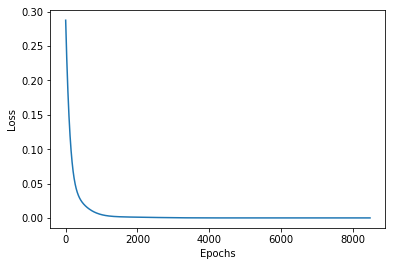

In [255]:
# Plot error vs epoch
plt.plot(regr.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Epochs');

In [256]:
# MLP weights -> WB-RAW RGB to XYZ 3x3 matrix conversion
regr.coefs_

[array([[ 0.79471269,  0.35876139,  0.06018896],
        [ 0.27784208,  0.99636603, -0.26390342],
        [ 0.12707532, -0.11484679,  1.21830966]])]

In [257]:
# MLP biases -> nearly 0's
regr.intercepts_

[array([-0.01081357, -0.01022717, -0.00390697])]

In [258]:
# Prediction
Y_pred = regr.predict(X)

# Clip to 0..1 range
# Y_pred[Y_pred < 0] = 0.0
# Y_pred[Y_pred > 1] = 1.0

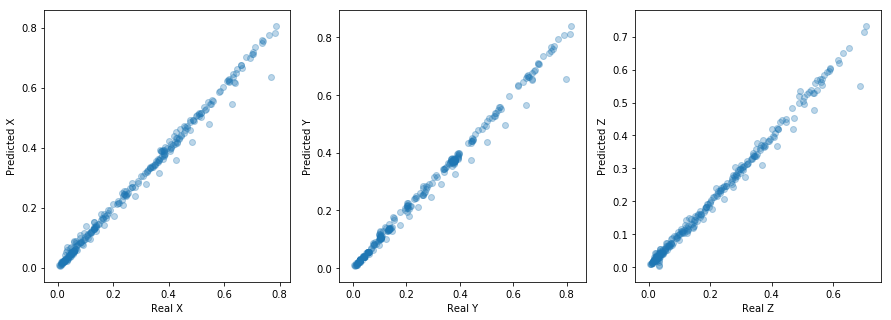

In [259]:
plt.subplots(figsize=(15, 5))

plt.subplot(131)
plt.scatter(Y[:, 0], Y_pred[:, 0], alpha=0.3)
plt.ylabel('Predicted X')
plt.xlabel('Real X')

plt.subplot(132)
plt.scatter(Y[:, 1], Y_pred[:, 1], alpha=0.3)
plt.ylabel('Predicted Y')
plt.xlabel('Real Y')

plt.subplot(133)
plt.scatter(Y[:, 2], Y_pred[:, 2], alpha=0.3)
plt.ylabel('Predicted Z')
plt.xlabel('Real Z');

### Dense NN

In [248]:
# Load MLP (once trained and saved)
with open('mlp_(200, 200)_relu_identity.pkl', 'rb') as f:
    regr = pickle.load(f)

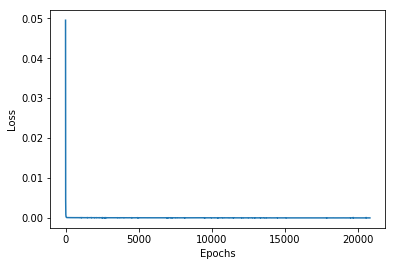

In [249]:
# Plot error vs epoch
plt.plot(regr.loss_curve_)
plt.ylabel('Loss')
plt.xlabel('Epochs');

In [250]:
# MLP weights
regr.coefs_

[array([[-4.31382451e-02,  3.32246694e-01,  7.97690181e-02,
          6.66339636e-02, -1.18274878e-01, -1.31874712e-01,
         -1.51948952e-01,  1.08893523e-01,  1.01354227e-01,
          2.77083707e-02, -1.64842684e-01,  1.46287251e-01,
          5.66813792e-03, -9.89095943e-02, -1.68466031e-01,
         -8.19482871e-02, -6.73095337e-02,  8.51227505e-03,
         -1.08529796e-01, -1.67865738e-01,  3.07812994e-02,
         -1.23956775e-01, -7.14691821e-02, -4.59502712e-02,
         -9.12108136e-03,  9.80551743e-02, -2.45318228e-01,
          7.01531665e-04,  3.17759134e-02, -1.55948922e-01,
         -4.31049046e-02, -7.32977656e-02, -3.40552607e-01,
          2.40168655e-01,  1.60103362e-01,  4.08114772e-03,
         -1.04554193e-01, -1.38336804e-01,  1.28218187e-01,
         -2.05780236e-02, -1.29958734e-01, -2.63833258e-02,
         -1.60096295e-01,  1.32374944e-01, -8.29413210e-02,
         -1.80520023e-02, -3.60555615e-02, -1.46926504e-01,
         -1.37854327e-03, -1.16880544e-0

In [251]:
# MLP biases
regr.intercepts_

[array([-0.11383368, -0.0872401 , -0.11105702, -0.27422504, -0.13044092,
        -0.02779896, -0.10097449,  0.03238332,  0.01626854,  0.05331298,
        -0.15840335,  0.04099595,  0.00831358, -0.14380837,  0.00734514,
         0.01187231, -0.15091937, -0.0767186 ,  0.00170575, -0.00067855,
        -0.29402688, -0.09993761, -0.044537  , -0.00532163,  0.07757272,
        -0.04507286, -0.10258801,  0.0057422 , -0.15930729, -0.08512232,
         0.01623154,  0.04508215, -0.01012339,  0.00346944, -0.13507035,
        -0.03674277,  0.07681647, -0.08854919, -0.10829573, -0.04219473,
        -0.16501918, -0.05053153, -0.09921599, -0.06768872, -0.13074135,
        -0.0083663 , -0.00379961, -0.00170348,  0.00208884, -0.00940156,
        -0.14203372, -0.00156361,  0.0081233 , -0.01342307, -0.02349825,
        -0.12805314, -0.0743467 , -0.04707791,  0.06924875,  0.07708045,
        -0.04947984,  0.03599923,  0.00199729, -0.09035219, -0.0788985 ,
        -0.11936124, -0.08735014, -0.10697583, -0.1

In [252]:
# Prediction
Y_pred = regr.predict(X)

# Clip to 0..1 range
# Y_pred[Y_pred < 0] = 0.0
# Y_pred[Y_pred > 1] = 1.0

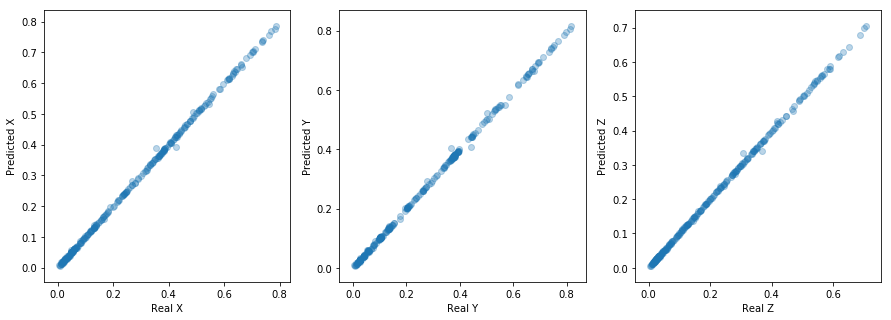

In [253]:
plt.subplots(figsize=(15, 5))

plt.subplot(131)
plt.scatter(Y[:, 0], Y_pred[:, 0], alpha=0.3)
plt.ylabel('Predicted X')
plt.xlabel('Real X')

plt.subplot(132)
plt.scatter(Y[:, 1], Y_pred[:, 1], alpha=0.3)
plt.ylabel('Predicted Y')
plt.xlabel('Real Y')

plt.subplot(133)
plt.scatter(Y[:, 2], Y_pred[:, 2], alpha=0.3)
plt.ylabel('Predicted Z')
plt.xlabel('Real Z');

## XYZ to Lab conversion: delta E